<h1><center>Text Classification Model Selection</center></h1>

In [ ]:
!pip install scikit-learn
!pip install keras
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 582.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=4d7cbcdb47ddc191a6fe1027743d8912fb9f8762a142cf8bbd6f81a65ab91ed1
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import time
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import decomposition, ensemble
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import np_utils
from xgboost import XGBClassifier
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
print(sklearn.__version__)
print(tf.__version__)

1.2.2
2.15.0


Confusion Matrix

In [ ]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

# Vars

In [ ]:
TEXT = "preprocessed_text"
LABEL = "label"

#Models

In [ ]:
save_results           = True
multinomial_naive_bayes = True
k_nn_model             = True
random_forest          = True
xgboost_classifier     = True
lstm                   = True

# Metrics

In [ ]:
score_metrics = {'acc': accuracy_score,
               'balanced_accuracy': balanced_accuracy_score,
               'prec': precision_score,
               'recall': recall_score,
               'f1-score': f1_score,
               'tp': tp, 'tn': tn,
               'fp': fp, 'fn': fn,
               "roc_auc":roc_auc_score}

# Labeled Data

In [ ]:
df_label = pd.read_csv('/content/df_labeled_cleaned_final.csv')

In [ ]:
df_label

,title,label,link,preprocessed_text
0,️ LACTOGEN PREMATUR BBLR 400 GRAM,Legal,https://shopee.co.id/️-LACTOGEN-PREMATUR-BBLR-...,lactogen prematur bblr gram
1,‼️CUCI GUDANG‼️ BATITA 1+ 900GRAM | TANPA DUS ...,Legal,https://shopee.co.id/‼️CUCI-GUDANG‼️-BATITA-1-...,cuci gudang batita gram dus madu susu formula ...
2,‼️CUCI GUDANG‼️ BATITA 1+ 900GRAM | VANILA | 1...,Legal,https://shopee.co.id/‼️CUCI-GUDANG‼️-BATITA-1-...,cuci gudang batita gram vanila susu formula tu...
3,‼️CUCI GUDANG‼️ DATITA 3+ 900GRAM | TANPA DUS ...,Legal,https://shopee.co.id/‼️CUCI-GUDANG‼️-DATITA-3-...,cuci gudang datita gram dus madu susu formula ...
4,‼️CUCI GUDANG‼️ DATITA 3+ 900GRAM | VANILA | 3...,Legal,https://shopee.co.id/‼️CUCI-GUDANG‼️-DATITA-3-...,cuci gudang datita gram vanila susu formula tu...
...,...,...,...,...
2754,Ternak Syams - Premium Susu Kambing Etawa Kolo...,Ilegal,https://shopee.co.id/Ternak-Syams-Premium-Susu...,ternak syams premium susu kambing etawa kolost...
2755,Totole kaldu jamur 200 gram,Legal,https://shopee.co.id/Totole-kaldu-jamur-200-gr...,totole kaldu jamur gram
2756,Trieste Italian Syrup 650mL - Coffee Syrup : C...,Ilegal,https://shopee.co.id/Trieste-Italian-Syrup-650...,trieste italian syrup ml coffee syrup caramel ...
2757,Wilmond Mandarin Orange in Syrup 312gr - Buah ...,Legal,https://shopee.co.id/Wilmond-Mandarin-Orange-i...,wilmond mandarin orange in syrup gr buah jeruk...


In [ ]:
df_label['preprocessed_text'].sample(10)

2200                 snack kilo gurih gr free bubble wrap
2411                       vidoran xmarr vanila madu gram
1985           sgm ananda gain g susu risiko gagal tumbuh
1200         keripik usus ayam enak halalsnack kilo murah
2423                                      vidoran xmart g
2184    snack kilo gr jagung ausy jagung arab cemilan ...
1904                                  roka toples isi exp
2097                  sgm eksplor gain optigrow vanila gr
2477    want want senbei gr rice cracker asin kracker ...
773     dewars white label ml scotch whisky indoalkoho...
Name: preprocessed_text, dtype: object

In [ ]:
pattern = ['gram', 'ml', 'kg', 'gr', 'pcs', 'ltr', 'liter', 'oz', 'lb', 'cc', 'pack', 'box', 'bottle', 'jar', 'can', 'piece', 'slice', 'dozen']
df_label['preprocessed_text'] = df_label['preprocessed_text'].replace(pattern, '', regex=True)

In [ ]:
import re

In [ ]:
df = df_label[['preprocessed_text', 'label']].copy()

In [ ]:
df

,preprocessed_text,label
0,lactogen prematur bblr,Legal
1,cuci gudang batita dus madu susu formula tumb...,Legal
2,cuci gudang batita vanila susu formula tumbuh...,Legal
3,cuci gudang datita dus madu susu formula tumb...,Legal
4,cuci gudang datita vanila susu formula tumbuh...,Legal
...,...,...
2754,ternak syams premium susu kambing etawa kolost...,Ilegal
2755,totole kaldu jamur,Legal
2756,trieste italian syrup coffee syrup caramel va...,Ilegal
2757,wilmond mandarin orange in syrup buah jeruk m...,Legal


In [ ]:
df[TEXT].fillna('', inplace=True)

In [ ]:
df.shape

(2759, 2)

# Train-test Split

In [ ]:
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df[TEXT], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

In [ ]:
train_x.shape, valid_x.shape, y_train.shape, y_valid.shape

((2207,), (552,), (2207,), (552,))

# Label Mapping

In [ ]:
label_mapping = {'Legal': 0, 'Ilegal': 1}
train_y = [label_mapping[label] for label in y_train]
valid_y = [label_mapping[label] for label in y_valid]

In [ ]:
y_train.value_counts()

label
Ilegal    1161
Legal     1046
Name: count, dtype: int64

In [ ]:
y_valid.value_counts()

label
Ilegal    291
Legal     261
Name: count, dtype: int64

In [ ]:
unique, counts = np.unique(train_y, return_counts=True)
dict(zip(unique, counts))

{0: 1046, 1: 1161}

In [ ]:
unique, counts = np.unique(valid_y, return_counts=True)
dict(zip(unique, counts))

{0: 261, 1: 291}

## Class Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)

In [ ]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')
# Determined if the dataset is balanced or imbalanced
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")

Class weight: 0.9505	class: Ilegal
Class weight: 1.055	class: Legal

The dataset is balanced (ratio=0.9)


In [ ]:
# Keep the unique label corresponding to their encoding correspondance
labels = df[LABEL].unique()

In [ ]:
labels

array(['Legal', 'Ilegal'], dtype=object)

# Feature Selection

## Bag Of Words (CountVectorizer)

In [ ]:
# create a count vectorizer object
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', binary=True)
count_vect.fit(df[TEXT])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [ ]:
xtrain_count

<2207x3141 sparse matrix of type '<class 'numpy.int64'>'
	with 16833 stored elements in Compressed Sparse Row format>

In [ ]:
xtrain_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
unique, counts = np.unique(xtrain_count.toarray(), return_counts=True)
dict(zip(unique, counts))

{0: 6915354, 1: 16833}

In [ ]:
len(count_vect.vocabulary_.keys())

3141

In [ ]:
len(count_vect.get_feature_names_out())

3141

In [ ]:
feature_names = count_vect.get_feature_names_out()
transformed_array = xtrain_count.toarray()
transformed_df = pd.DataFrame(transformed_array, columns=feature_names)
before_after_table = pd.concat([train_x.reset_index(drop=True), transformed_df], axis=1)

In [ ]:
filtered_columns = [col for col in before_after_table.columns if col != 'preprocessed_text']
mask = before_after_table[filtered_columns].gt(0).any(axis=1)
filtered_table = before_after_table[mask]
result = filtered_table[['preprocessed_text'] + filtered_columns]
result

,preprocessed_text,a,aademia,aatal,ab,abc,abdi,abidin,abon,absolute,aceh,aci,acious,acti,actiduobio,active,activgo,ade,aduhai,af,afif,afkir,age,aged,agen,aging,agung,agustus,agustusjuli,ahh,ai,aids,ailisha,ain,aioi,air,aja,ajay,ajisan,ajmala,ajwa,akar,akasia,aktif,akut,al,ala,alami,alat,alc,alcohol,aldy,alen,alergi,alessio,alfort,alfredo,ali,alkes,alkohol,all,allamanda,almarai,almarailunarainbowbonny,almasnack,almond,almondmederaisinwalnutcranberryciaseedflekseed,almondwalnutsunflowerpumkinmentechia,almost,aln,alster,altalita,altara,altat,am,aman,amaou,ameraja,ameri,amh,amondeu,amplang,ampuh,an,anak,anaksusu,ananda,anandagain,and,andville,aneka,ang,angciu,anggur,angker,angmer,anker,anola,antaka,antan,anter,anti,antiaging,antibody,antioksidan,antis,antiseptik,anxiet,ao,aoi,aoka,ape,apel,apelicious,api,apidin,apollo,apotek,apple,april,arab,arabturky,arak,arakcocktail,ardentha,area,aren,arenga,ark,arla,arnotts,arrival,arrowroot,art,artis,arzanka,asah,asam,asem,asi,asin,asli,asoka,asparagus,assorted,assortment,astor,at,ata,atanan,atas,atis,atur,aug,aultmore,aumin,australia,australian,austria,ausy,authentic,avenue,avocado,aw,awet,awie,ayam,b,ba,bab,babeh,babi,baby,babycrab,baca,badak,badan,bag,bagong,bagus,bahan,baik,bakar,baked,bakery,baking,baklava,bakpia,bakso,baksososis,baksososisnugget,bal,bala,balado,baladopeteterasiteri,balall,baliarak,baliarbal,baliblendedwhiskeyoakbali,balihai,balikpapan,baliminuman,balimoon,balinese,balioakbaliblendedwhiskey,balioakbaliminumanbali,balioleh,balita,ball,ballantines,balls,balok,balon,balungsugih,bamboe,ban,banana,band,banda,bandar,bandrek,bandrex,bandun,bandung,bandungbaso,bang,banget,bangket,bangkok,bango,bangsreng,banket,bannegara,bantal,bantat,bantet,banting,bantu,baobab,bar,barari,barbekyu,barcelona,barco,barcode,baricho,barrel,baru,baruexp,basah,...,torbacik,tortila,tortilla,tos,totole,touch,tower,town,tradisiona,tradisional,traditional,trail,travel,trendy,trenggalek,trf,trial,triangle,trieste,tripedtide,triple,triplesure,tropical,tropis,truffe,truffle,trupeecoklat,tteobokki,tteokbokki,tts,tua,tualen,tub,tuban,tube,tubruk,tubuh,tulang,tulungagung,tumbler,tumbuh,tun,tuna,tunisia,turkey,turki,turkiye,turky,turmeric,turun,tutup,twin,twis,twiscorn,twist,twix,tx,tyl,ua,uaglow,ube,ubi,ud,udang,udin,uduk,ugc,ugcumi,uht,uk,ukur,ultima,ultimate,ulu,umbi,umi,umpan,umroh,umur,unaco,ungu,unico,unik,universal,unt,untir,untukanaktidakmaumakan,up,update,urat,uratnyeri,ursnacks,urut,usa,usaha,usia,usus,utk,utuh,uwa,uwuh,v,vacum,vacuum,vakum,valentine,valeo,value,van,vanhouten,vanila,vanilacoklat,vanilamadu,vanilamaducokelat,vanilla,vanillamadu,vape,vapeers,varian,variant,variants,vegan,vegetable,vegetarian,vegetarianalmondraisineen,vegetarianla,veggies,velfit,venus,vertigo,vibe,vidoran,vidorant,vigos,village,vinegar,vinyard,viral,virale,viraljajanan,vita,vitagold,vital,vitalitas,vitameal,vitamin,vitmen,vodka,vsop,vvhiskey,w,wafel,wafer,waffle,wainmart,wajib,walens,walker,wamena,wan,wangae,wangi,wanita,wanmei,wansin,want,warna,warni,warp,wasabi,water,wbblr,wedang,wheat,whey,whiskey,whisky,white,whole,wholesome,whsky,widyatmoosir,wijen,william,wilmond,wine,wineshao,wineshaoxing,winewansin,wing,wings,with,wnaraya,wonderful,wonhae,world,wortel,wost,wrap,wrapkardus,wulama,wyeth,wzf,x,xantangum,xcm,xiang,xiangjiu,xing,xingshao,xmarr,xmart,y,ya,yakon,yam,yangun,yasuka,yava,yawa,year,years,yee,yeosnarayaoishiyoriroot,yi,yo,yodium,yoghurt,yogurt,yola,yolk,yomas,yong,yoyic,ysolshop,yumbites,yummysalmond,yung,yura,yuzu,zaans,zat,zealand,zee,zero,zheng,zitrone,zoda,zu,zuriat
0,arak masak merah at cap loncengangciu at,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
filtered_columns = [col for col in before_after_table[25:26].columns if col != 'preprocessed_text']
mask = before_after_table[25:26][filtered_columns].gt(0).any(axis=1)
filtered_table = before_after_table[25:26][mask]
result = filtered_table[['preprocessed_text'] + filtered_columns]
result

,preprocessed_text,a,aademia,aatal,ab,abc,abdi,abidin,abon,absolute,aceh,aci,acious,acti,actiduobio,active,activgo,ade,aduhai,af,afif,afkir,age,aged,agen,aging,agung,agustus,agustusjuli,ahh,ai,aids,ailisha,ain,aioi,air,aja,ajay,ajisan,ajmala,ajwa,akar,akasia,aktif,akut,al,ala,alami,alat,alc,alcohol,aldy,alen,alergi,alessio,alfort,alfredo,ali,alkes,alkohol,all,allamanda,almarai,almarailunarainbowbonny,almasnack,almond,almondmederaisinwalnutcranberryciaseedflekseed,almondwalnutsunflowerpumkinmentechia,almost,aln,alster,altalita,altara,altat,am,aman,amaou,ameraja,ameri,amh,amondeu,amplang,ampuh,an,anak,anaksusu,ananda,anandagain,and,andville,aneka,ang,angciu,anggur,angker,angmer,anker,anola,antaka,antan,anter,anti,antiaging,antibody,antioksidan,antis,antiseptik,anxiet,ao,aoi,aoka,ape,apel,apelicious,api,apidin,apollo,apotek,apple,april,arab,arabturky,arak,arakcocktail,ardentha,area,aren,arenga,ark,arla,arnotts,arrival,arrowroot,art,artis,arzanka,asah,asam,asem,asi,asin,asli,asoka,asparagus,assorted,assortment,astor,at,ata,atanan,atas,atis,atur,aug,aultmore,aumin,australia,australian,austria,ausy,authentic,avenue,avocado,aw,awet,awie,ayam,b,ba,bab,babeh,babi,baby,babycrab,baca,badak,badan,bag,bagong,bagus,bahan,baik,bakar,baked,bakery,baking,baklava,bakpia,bakso,baksososis,baksososisnugget,bal,bala,balado,baladopeteterasiteri,balall,baliarak,baliarbal,baliblendedwhiskeyoakbali,balihai,balikpapan,baliminuman,balimoon,balinese,balioakbaliblendedwhiskey,balioakbaliminumanbali,balioleh,balita,ball,ballantines,balls,balok,balon,balungsugih,bamboe,ban,banana,band,banda,bandar,bandrek,bandrex,bandun,bandung,bandungbaso,bang,banget,bangket,bangkok,bango,bangsreng,banket,bannegara,bantal,bantat,bantet,banting,bantu,baobab,bar,barari,barbekyu,barcelona,barco,barcode,baricho,barrel,baru,baruexp,basah,...,torbacik,tortila,tortilla,tos,totole,touch,tower,town,tradisiona,tradisional,traditional,trail,travel,trendy,trenggalek,trf,trial,triangle,trieste,tripedtide,triple,triplesure,tropical,tropis,truffe,truffle,trupeecoklat,tteobokki,tteokbokki,tts,tua,tualen,tub,tuban,tube,tubruk,tubuh,tulang,tulungagung,tumbler,tumbuh,tun,tuna,tunisia,turkey,turki,turkiye,turky,turmeric,turun,tutup,twin,twis,twiscorn,twist,twix,tx,tyl,ua,uaglow,ube,ubi,ud,udang,udin,uduk,ugc,ugcumi,uht,uk,ukur,ultima,ultimate,ulu,umbi,umi,umpan,umroh,umur,unaco,ungu,unico,unik,universal,unt,untir,untukanaktidakmaumakan,up,update,urat,uratnyeri,ursnacks,urut,usa,usaha,usia,usus,utk,utuh,uwa,uwuh,v,vacum,vacuum,vakum,valentine,valeo,value,van,vanhouten,vanila,vanilacoklat,vanilamadu,vanilamaducokelat,vanilla,vanillamadu,vape,vapeers,varian,variant,variants,vegan,vegetable,vegetarian,vegetarianalmondraisineen,vegetarianla,veggies,velfit,venus,vertigo,vibe,vidoran,vidorant,vigos,village,vinegar,vinyard,viral,virale,viraljajanan,vita,vitagold,vital,vitalitas,vitameal,vitamin,vitmen,vodka,vsop,vvhiskey,w,wafel,wafer,waffle,wainmart,wajib,walens,walker,wamena,wan,wangae,wangi,wanita,wanmei,wansin,want,warna,warni,warp,wasabi,water,wbblr,wedang,wheat,whey,whiskey,whisky,white,whole,wholesome,whsky,widyatmoosir,wijen,william,wilmond,wine,wineshao,wineshaoxing,winewansin,wing,wings,with,wnaraya,wonderful,wonhae,world,wortel,wost,wrap,wrapkardus,wulama,wyeth,wzf,x,xantangum,xcm,xiang,xiangjiu,xing,xingshao,xmarr,xmart,y,ya,yakon,yam,yangun,yasuka,yava,yawa,year,years,yee,yeosnarayaoishiyoriroot,yi,yo,yodium,yoghurt,yogurt,yola,yolk,yomas,yong,yoyic,ysolshop,yumbites,yummysalmond,yung,yura,yuzu,zaans,zat,zealand,zee,zero,zheng,zitrone,zoda,zu,zuriat
25,momogi isi momogi stick snack extrudat long...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
result.replace(0, np.nan, inplace=True)

In [ ]:
result.dropna(axis=1)

,preprocessed_text,bgks,extrudat,isi,long,momogi,snack,stick
25,momogi isi momogi stick snack extrudat long...,1,1,1,1,1,1,1


## TF-IDF

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(df[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
print("word level tf-idf done")

word level tf-idf done


In [ ]:
xtrain_tfidf

<2207x3141 sparse matrix of type '<class 'numpy.float64'>'
	with 16833 stored elements in Compressed Sparse Row format>

In [ ]:
feature_names = tfidf_vect.get_feature_names_out()
transformed_array = xtrain_tfidf.toarray()
transformed_df = pd.DataFrame(transformed_array, columns=feature_names)
before_after_table = pd.concat([train_x.reset_index(drop=True), transformed_df], axis=1)

In [ ]:
filtered_columns = [col for col in before_after_table[25:26].columns if col != 'preprocessed_text']
mask = before_after_table[25:26][filtered_columns].gt(0).any(axis=1)
filtered_table = before_after_table[25:26][mask]
result = filtered_table[['preprocessed_text'] + filtered_columns]
result

,preprocessed_text,a,aademia,aatal,ab,abc,abdi,abidin,abon,absolute,aceh,aci,acious,acti,actiduobio,active,activgo,ade,aduhai,af,afif,afkir,age,aged,agen,aging,agung,agustus,agustusjuli,ahh,ai,aids,ailisha,ain,aioi,air,aja,ajay,ajisan,ajmala,ajwa,akar,akasia,aktif,akut,al,ala,alami,alat,alc,alcohol,aldy,alen,alergi,alessio,alfort,alfredo,ali,alkes,alkohol,all,allamanda,almarai,almarailunarainbowbonny,almasnack,almond,almondmederaisinwalnutcranberryciaseedflekseed,almondwalnutsunflowerpumkinmentechia,almost,aln,alster,altalita,altara,altat,am,aman,amaou,ameraja,ameri,amh,amondeu,amplang,ampuh,an,anak,anaksusu,ananda,anandagain,and,andville,aneka,ang,angciu,anggur,angker,angmer,anker,anola,antaka,antan,anter,anti,antiaging,antibody,antioksidan,antis,antiseptik,anxiet,ao,aoi,aoka,ape,apel,apelicious,api,apidin,apollo,apotek,apple,april,arab,arabturky,arak,arakcocktail,ardentha,area,aren,arenga,ark,arla,arnotts,arrival,arrowroot,art,artis,arzanka,asah,asam,asem,asi,asin,asli,asoka,asparagus,assorted,assortment,astor,at,ata,atanan,atas,atis,atur,aug,aultmore,aumin,australia,australian,austria,ausy,authentic,avenue,avocado,aw,awet,awie,ayam,b,ba,bab,babeh,babi,baby,babycrab,baca,badak,badan,bag,bagong,bagus,bahan,baik,bakar,baked,bakery,baking,baklava,bakpia,bakso,baksososis,baksososisnugget,bal,bala,balado,baladopeteterasiteri,balall,baliarak,baliarbal,baliblendedwhiskeyoakbali,balihai,balikpapan,baliminuman,balimoon,balinese,balioakbaliblendedwhiskey,balioakbaliminumanbali,balioleh,balita,ball,ballantines,balls,balok,balon,balungsugih,bamboe,ban,banana,band,banda,bandar,bandrek,bandrex,bandun,bandung,bandungbaso,bang,banget,bangket,bangkok,bango,bangsreng,banket,bannegara,bantal,bantat,bantet,banting,bantu,baobab,bar,barari,barbekyu,barcelona,barco,barcode,baricho,barrel,baru,baruexp,basah,...,torbacik,tortila,tortilla,tos,totole,touch,tower,town,tradisiona,tradisional,traditional,trail,travel,trendy,trenggalek,trf,trial,triangle,trieste,tripedtide,triple,triplesure,tropical,tropis,truffe,truffle,trupeecoklat,tteobokki,tteokbokki,tts,tua,tualen,tub,tuban,tube,tubruk,tubuh,tulang,tulungagung,tumbler,tumbuh,tun,tuna,tunisia,turkey,turki,turkiye,turky,turmeric,turun,tutup,twin,twis,twiscorn,twist,twix,tx,tyl,ua,uaglow,ube,ubi,ud,udang,udin,uduk,ugc,ugcumi,uht,uk,ukur,ultima,ultimate,ulu,umbi,umi,umpan,umroh,umur,unaco,ungu,unico,unik,universal,unt,untir,untukanaktidakmaumakan,up,update,urat,uratnyeri,ursnacks,urut,usa,usaha,usia,usus,utk,utuh,uwa,uwuh,v,vacum,vacuum,vakum,valentine,valeo,value,van,vanhouten,vanila,vanilacoklat,vanilamadu,vanilamaducokelat,vanilla,vanillamadu,vape,vapeers,varian,variant,variants,vegan,vegetable,vegetarian,vegetarianalmondraisineen,vegetarianla,veggies,velfit,venus,vertigo,vibe,vidoran,vidorant,vigos,village,vinegar,vinyard,viral,virale,viraljajanan,vita,vitagold,vital,vitalitas,vitameal,vitamin,vitmen,vodka,vsop,vvhiskey,w,wafel,wafer,waffle,wainmart,wajib,walens,walker,wamena,wan,wangae,wangi,wanita,wanmei,wansin,want,warna,warni,warp,wasabi,water,wbblr,wedang,wheat,whey,whiskey,whisky,white,whole,wholesome,whsky,widyatmoosir,wijen,william,wilmond,wine,wineshao,wineshaoxing,winewansin,wing,wings,with,wnaraya,wonderful,wonhae,world,wortel,wost,wrap,wrapkardus,wulama,wyeth,wzf,x,xantangum,xcm,xiang,xiangjiu,xing,xingshao,xmarr,xmart,y,ya,yakon,yam,yangun,yasuka,yava,yawa,year,years,yee,yeosnarayaoishiyoriroot,yi,yo,yodium,yoghurt,yogurt,yola,yolk,yomas,yong,yoyic,ysolshop,yumbites,yummysalmond,yung,yura,yuzu,zaans,zat,zealand,zee,zero,zheng,zitrone,zoda,zu,zuriat
25,momogi isi momogi stick snack extrudat long...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
result.replace(0, np.nan, inplace=True)
result.dropna(axis=1)

,preprocessed_text,bgks,extrudat,isi,long,momogi,snack,stick
25,momogi isi momogi stick snack extrudat long...,0.361762,0.343939,0.325992,0.321484,0.662586,0.132289,0.291015


In [ ]:
def report(clf, x_train, y_train, x_valid, y_valid, name='classifier', cv=5, dict_scoring=None, fit_params=None):
    # Convert scoring functions to scorers
    if dict_scoring is not None:
        score = dict_scoring.copy()
        for key in score.keys():
            score[key] = make_scorer(score[key])

    print("Model: ", name)
    print("Model Parameter: ", clf.get_params())

    # Prepare the cross-validator
    cross_validator = KFold(n_splits=cv)

    # Perform cross-validation
    scores = cross_validate(clf, x_train, y_train, scoring=score, cv=cross_validator,
                            return_train_score=False, n_jobs=-1, fit_params=fit_params)

    # Prepare lists to store index and values for the DataFrame
    index = []
    value = []
    index.append("Model")
    value.append(name)

    # Add data count for each fold
    fold_counts = [len(val_idx) for _, val_idx in cross_validator.split(x_train)]
    for fold_index, count in enumerate(fold_counts):
        index.append(f"data_count_cv{fold_index + 1}")
        value.append(count)

    # Iterate over the scores and collect the mean and std for each metric
    for metric in scores:
        if metric == "estimator":
            continue
        for fold_index, fold_score in enumerate(scores[metric]):
            index.append(f"{metric}_cv{fold_index + 1}")
            value.append(fold_score)

        index.append(f"{metric}_mean")
        value.append(np.mean(scores[metric]))
        index.append(f"{metric}_std")
        value.append(np.std(scores[metric]))

    # Make predictions on validation set
    y_pred = clf.predict(x_valid)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    print("Precision on Test Data: ", precision)
    print("Recall on Test Data: ", recall)
    print("F1 Score on Test Data: ", f1)

    index.extend(["Precision", "Recall", "F1 Score"])
    value.extend([precision, recall, f1])

    # Calculate ROC/AUC
    y_probs = clf.predict_proba(x_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_probs)

    index.append("ROC/AUC")
    value.append(auc)

    print("ROC/AUC on Test Data: ", auc)

    # Create subplots for ROC and Precision-Recall curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_valid, y_probs)
    axes[0].plot(fpr, tpr, linestyle='-', label=name)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_valid, y_probs)
    axes[1].plot(recall, precision, linestyle='-', label=name)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(data=value, index=index).T

#Naive Bayes

In [ ]:
import joblib

Model:  NB_Count_Vectors
Model Parameter:  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Precision on Test Data:  0.814935064935065
Recall on Test Data:  0.8625429553264605
F1 Score on Test Data:  0.8380634390651085
ROC/AUC on Test Data:  0.8910152598385802


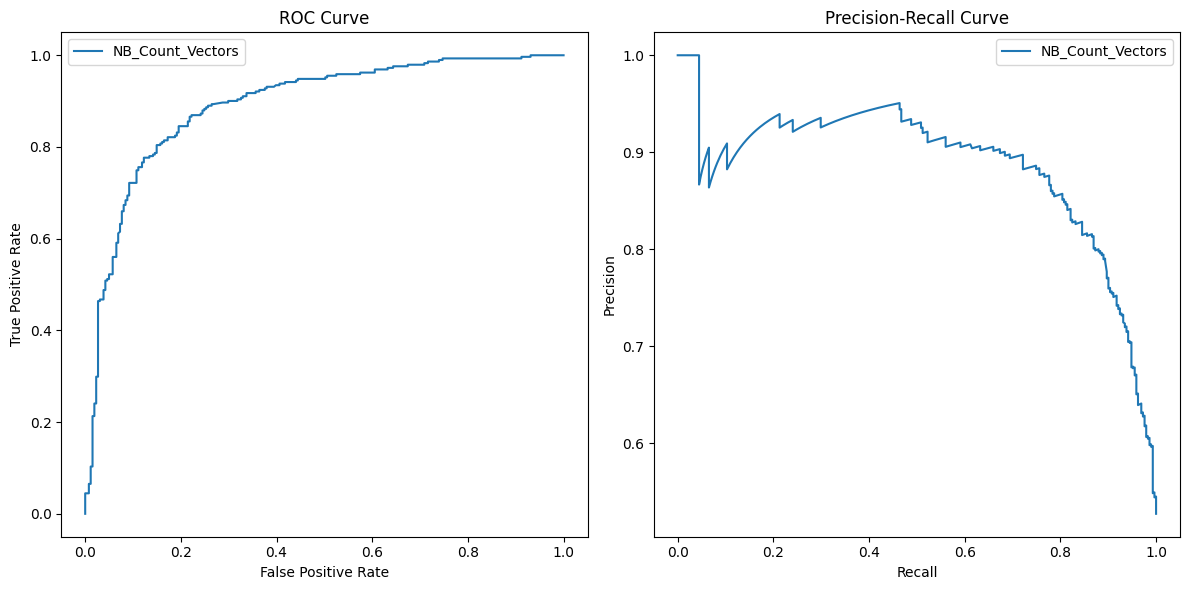

Model:  NB_WordLevel_TF-IDF
Model Parameter:  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Precision on Test Data:  0.8089171974522293
Recall on Test Data:  0.872852233676976
F1 Score on Test Data:  0.8396694214876034
ROC/AUC on Test Data:  0.8957683243143607


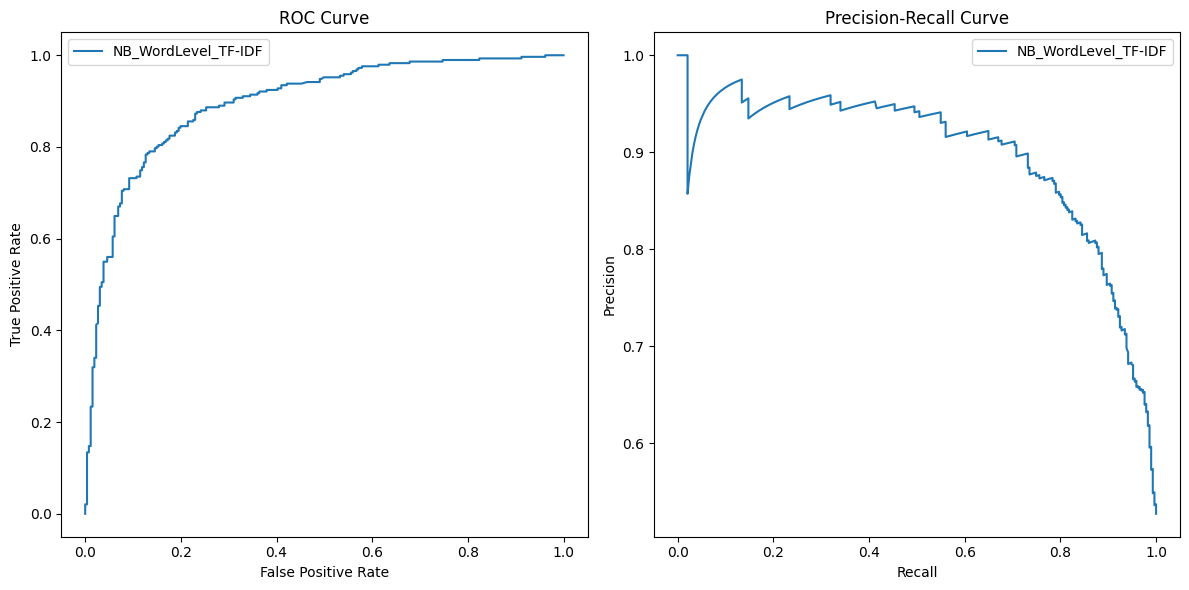

In [ ]:
if multinomial_naive_bayes:
    model_oh = naive_bayes.MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    model_oh.fit(xtrain_count, train_y)

    model_tf = naive_bayes.MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    model_tf.fit(xtrain_tfidf, train_y)

    dfs_to_concat = [
        report(model_oh, xtrain_count, train_y, xvalid_count, valid_y, name='NB_Count_Vectors', cv=5, dict_scoring=score_metrics),
        report(model_tf, xtrain_tfidf, train_y, xvalid_tfidf, valid_y, name='NB_WordLevel_TF-IDF', cv=5, dict_scoring=score_metrics)
    ]

    nb_cv_results = pd.concat(dfs_to_concat)

    joblib.dump(model_oh, 'nb_model_oh.joblib')
    joblib.dump(model_tf, 'nb_model_tf.joblib')

In [ ]:
len(train_y)/5

441.4

In [ ]:
len(train_y)

2207

In [ ]:
nb_cv_results

,Model,data_count_cv1,data_count_cv2,data_count_cv3,data_count_cv4,data_count_cv5,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,score_time_cv3,score_time_cv4,score_time_cv5,score_time_mean,score_time_std,test_acc_cv1,test_acc_cv2,test_acc_cv3,test_acc_cv4,test_acc_cv5,test_acc_mean,test_acc_std,test_balanced_accuracy_cv1,test_balanced_accuracy_cv2,test_balanced_accuracy_cv3,test_balanced_accuracy_cv4,test_balanced_accuracy_cv5,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std,test_tp_cv1,test_tp_cv2,test_tp_cv3,test_tp_cv4,test_tp_cv5,test_tp_mean,test_tp_std,test_tn_cv1,test_tn_cv2,test_tn_cv3,test_tn_cv4,test_tn_cv5,test_tn_mean,test_tn_std,test_fp_cv1,test_fp_cv2,test_fp_cv3,test_fp_cv4,test_fp_cv5,test_fp_mean,test_fp_std,test_fn_cv1,test_fn_cv2,test_fn_cv3,test_fn_cv4,test_fn_cv5,test_fn_mean,test_fn_std,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std,Precision,Recall,F1 Score,ROC/AUC
0,NB_Count_Vectors,442,442,441,441,441,0.005901,0.005938,0.0046,0.005455,0.004422,0.005263,0.00064,0.019829,0.019736,0.019905,0.020712,0.014382,0.018913,0.002292,0.821267,0.852941,0.804989,0.827664,0.85941,0.833254,0.020227,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097,0.83913,0.861111,0.814961,0.799107,0.86758,0.836378,0.026232,0.821277,0.878543,0.841463,0.852381,0.852018,0.849136,0.01854,0.830108,0.869739,0.828,0.824885,0.859729,0.842492,0.018509,193,217,207,179,190,197.2,13.332667,170,160,148,186,189,170.6,15.486769,37,35,47,45,29,38.6,6.621178,42,30,39,31,33,35.0,4.690416,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097,0.814935,0.862543,0.838063,0.891015
0,NB_WordLevel_TF-IDF,442,442,441,441,441,0.01289,0.005479,0.004948,0.005229,0.004114,0.006532,0.003212,0.024231,0.020145,0.019819,0.019797,0.01237,0.019273,0.003836,0.816742,0.861991,0.811791,0.818594,0.866213,0.835066,0.023849,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143,0.82906,0.866142,0.814672,0.782609,0.862832,0.831063,0.031178,0.825532,0.890688,0.857724,0.857143,0.874439,0.861105,0.021659,0.827292,0.878244,0.835644,0.818182,0.868597,0.845592,0.023582,194,220,211,180,195,200.0,14.014278,167,161,147,181,187,168.6,14.277255,40,34,48,50,31,40.6,7.472617,41,27,35,30,28,32.2,5.192302,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143,0.808917,0.872852,0.839669,0.895768


# KNN

Model:  kNN_Count_Vectors
Model Parameter:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Precision on Test Data:  0.8104575163398693
Recall on Test Data:  0.852233676975945
F1 Score on Test Data:  0.830820770519263
ROC/AUC on Test Data:  0.8996984898158022


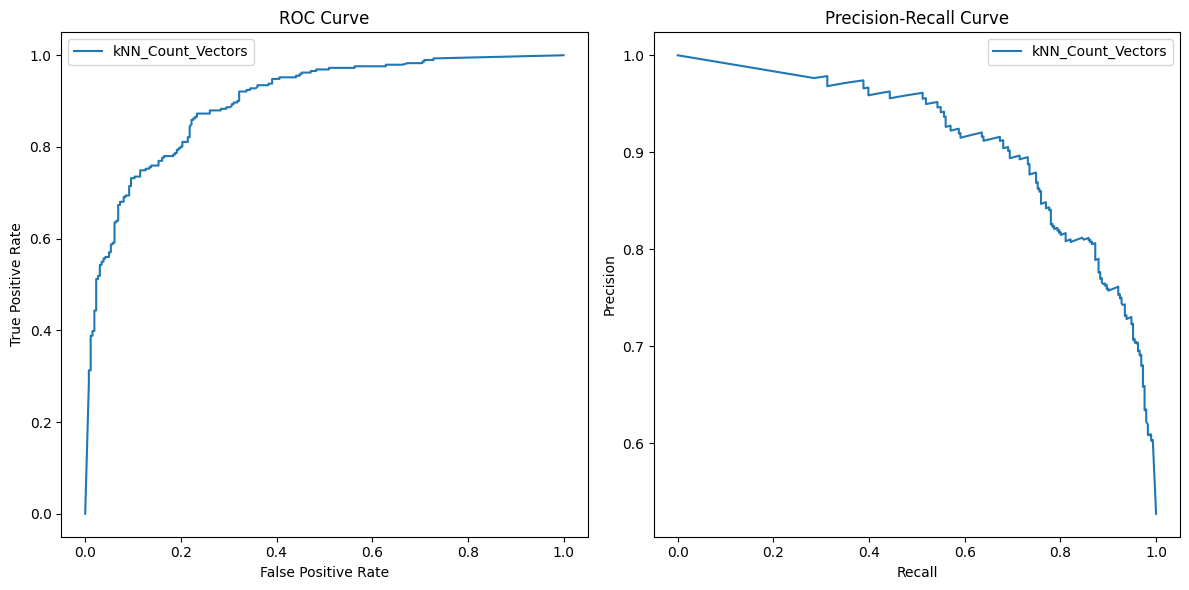

Model:  kNN_WordLevel_TF-IDF
Model Parameter:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Precision on Test Data:  0.8169934640522876
Recall on Test Data:  0.8591065292096219
F1 Score on Test Data:  0.8375209380234506
ROC/AUC on Test Data:  0.9023712656844545


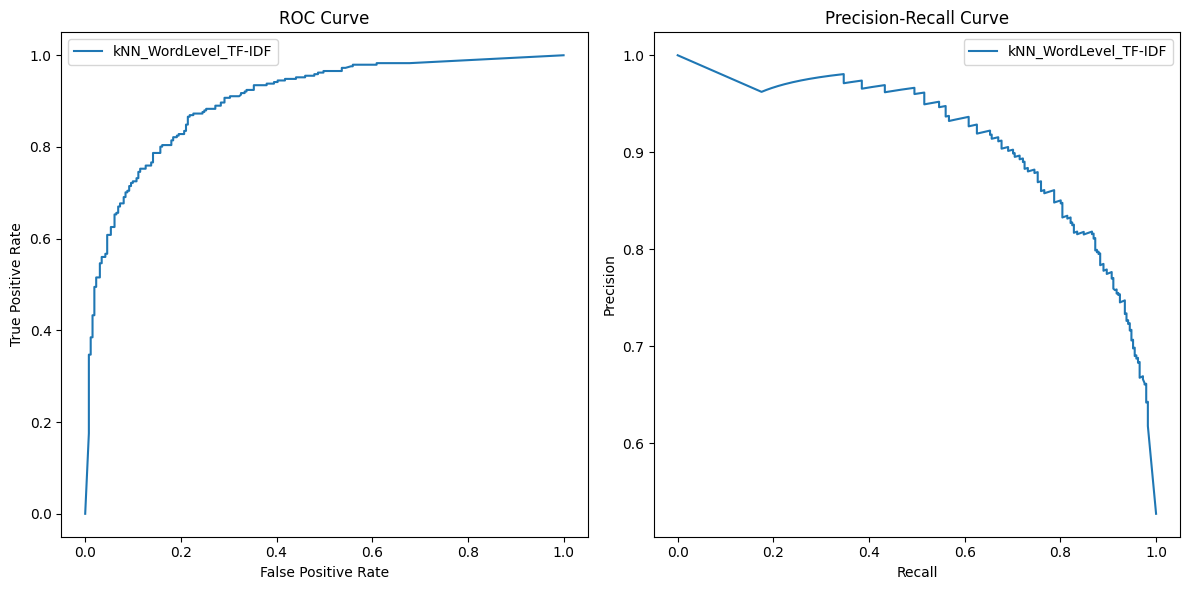

In [ ]:
if k_nn_model:
    model_oh = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1)
    model_oh.fit(xtrain_count, train_y)

    model_tf = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1)
    model_tf.fit(xtrain_tfidf, train_y)

    dfs_to_concat = [
        report(model_oh, xtrain_count, train_y, xvalid_count, valid_y, name='kNN_Count_Vectors', cv=5, dict_scoring=score_metrics),
        report(model_tf, xtrain_tfidf, train_y, xvalid_tfidf, valid_y, name='kNN_WordLevel_TF-IDF', cv=5, dict_scoring=score_metrics)
      ]

    knn_cv_results = pd.concat(dfs_to_concat)

    joblib.dump(model_oh, 'knn_model_oh.joblib')
    joblib.dump(model_tf, 'knn_model_tf.joblib')

In [ ]:
knn_cv_results

,Model,data_count_cv1,data_count_cv2,data_count_cv3,data_count_cv4,data_count_cv5,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,score_time_cv3,score_time_cv4,score_time_cv5,score_time_mean,score_time_std,test_acc_cv1,test_acc_cv2,test_acc_cv3,test_acc_cv4,test_acc_cv5,test_acc_mean,test_acc_std,test_balanced_accuracy_cv1,test_balanced_accuracy_cv2,test_balanced_accuracy_cv3,test_balanced_accuracy_cv4,test_balanced_accuracy_cv5,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std,test_tp_cv1,test_tp_cv2,test_tp_cv3,test_tp_cv4,test_tp_cv5,test_tp_mean,test_tp_std,test_tn_cv1,test_tn_cv2,test_tn_cv3,test_tn_cv4,test_tn_cv5,test_tn_mean,test_tn_std,test_fp_cv1,test_fp_cv2,test_fp_cv3,test_fp_cv4,test_fp_cv5,test_fp_mean,test_fp_std,test_fn_cv1,test_fn_cv2,test_fn_cv3,test_fn_cv4,test_fn_cv5,test_fn_mean,test_fn_std,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std,Precision,Recall,F1 Score,ROC/AUC
0,kNN_Count_Vectors,442,442,441,441,441,0.002915,0.003622,0.006026,0.006436,0.002715,0.004343,0.001576,0.162054,0.135022,0.159241,0.134946,0.108392,0.139931,0.019524,0.764706,0.823529,0.809524,0.78458,0.85941,0.80835,0.032585,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756,0.729825,0.814126,0.824,0.742616,0.842553,0.790624,0.045529,0.885106,0.88664,0.837398,0.838095,0.887892,0.867026,0.023924,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966,208,219,206,176,198,201.4,14.361058,130,145,151,170,181,155.4,18.117395,77,50,44,61,37,53.8,14.019986,27,28,40,34,25,30.8,5.491812,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756,0.810458,0.852234,0.830821,0.899698
0,kNN_WordLevel_TF-IDF,442,442,441,441,441,0.007955,0.003655,0.002861,0.00272,0.00257,0.003952,0.002036,0.318857,0.265272,0.197531,0.178623,0.135565,0.21917,0.065062,0.832579,0.88009,0.809524,0.807256,0.868481,0.839586,0.029912,0.832768,0.878677,0.804816,0.809091,0.868567,0.838784,0.030167,0.851528,0.894309,0.818898,0.770563,0.876712,0.842402,0.043973,0.829787,0.890688,0.845528,0.847619,0.860987,0.854922,0.020442,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609,195,220,208,178,192,198.6,14.333178,173,169,149,178,191,172.0,13.682105,34,26,46,53,27,37.2,10.647065,40,27,38,32,31,33.6,4.758151,0.832768,0.878677,0.804816,0.809091,0.868567,0.838784,0.030167,0.816993,0.859107,0.837521,0.902371


#RandomForest

Model:  RF_Count_Vectors
Model Parameter:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Precision on Test Data:  0.8631578947368421
Recall on Test Data:  0.845360824742268
F1 Score on Test Data:  0.8541666666666666
ROC/AUC on Test Data:  0.9208766178193832


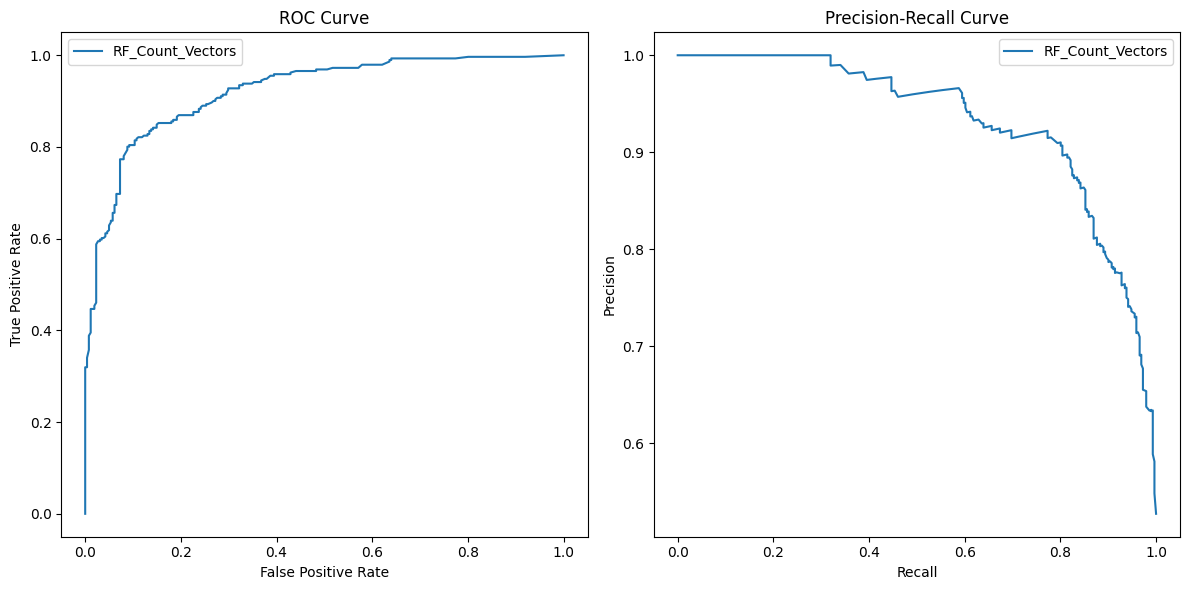

Model:  RF_WordLevel_TF-IDF
Model Parameter:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Precision on Test Data:  0.8606271777003485
Recall on Test Data:  0.8487972508591065
F1 Score on Test Data:  0.8546712802768167
ROC/AUC on Test Data:  0.9167357901805112


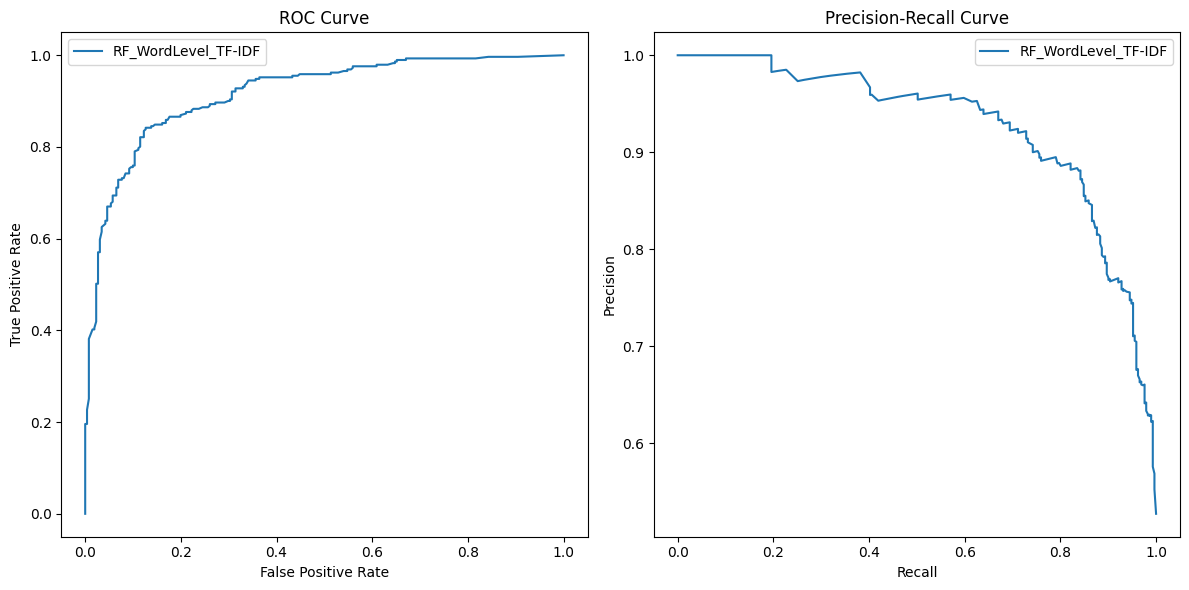

In [ ]:
if random_forest:
    model_oh = ensemble.RandomForestClassifier(bootstrap=True, min_impurity_decrease=1e-7, n_jobs=-1, random_state=42)
    model_oh.fit(xtrain_count, train_y)

    model_tf = ensemble.RandomForestClassifier(bootstrap=True, min_impurity_decrease=1e-7, n_jobs=-1, random_state=42)
    model_tf.fit(xtrain_tfidf, train_y)

    dfs_to_concat = [
        report(model_oh, xtrain_count, train_y, xvalid_count, valid_y, name='RF_Count_Vectors', cv=5, dict_scoring=score_metrics),
        report(model_tf, xtrain_tfidf, train_y, xvalid_tfidf, valid_y, name='RF_WordLevel_TF-IDF', cv=5, dict_scoring=score_metrics)
      ]

    rf_cv_results = pd.concat(dfs_to_concat)

    joblib.dump(model_oh, 'rf_model_oh.joblib')
    joblib.dump(model_tf, 'rf_model_tf.joblib')

In [ ]:
rf_cv_results

,Model,data_count_cv1,data_count_cv2,data_count_cv3,data_count_cv4,data_count_cv5,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,score_time_cv3,score_time_cv4,score_time_cv5,score_time_mean,score_time_std,test_acc_cv1,test_acc_cv2,test_acc_cv3,test_acc_cv4,test_acc_cv5,test_acc_mean,test_acc_std,test_balanced_accuracy_cv1,test_balanced_accuracy_cv2,test_balanced_accuracy_cv3,test_balanced_accuracy_cv4,test_balanced_accuracy_cv5,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std,test_tp_cv1,test_tp_cv2,test_tp_cv3,test_tp_cv4,test_tp_cv5,test_tp_mean,test_tp_std,test_tn_cv1,test_tn_cv2,test_tn_cv3,test_tn_cv4,test_tn_cv5,test_tn_mean,test_tn_std,test_fp_cv1,test_fp_cv2,test_fp_cv3,test_fp_cv4,test_fp_cv5,test_fp_mean,test_fp_std,test_fn_cv1,test_fn_cv2,test_fn_cv3,test_fn_cv4,test_fn_cv5,test_fn_mean,test_fn_std,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std,Precision,Recall,F1 Score,ROC/AUC
0,RF_Count_Vectors,442,442,441,441,441,4.074641,4.311946,2.702504,2.562595,1.306396,2.991616,1.097618,0.151132,0.114341,0.078498,0.072852,0.056034,0.094571,0.034074,0.864253,0.855204,0.827664,0.825397,0.891156,0.852735,0.024458,0.86457,0.85803,0.827455,0.826407,0.891245,0.853541,0.024414,0.882096,0.899563,0.857143,0.798206,0.899543,0.86731,0.037886,0.859574,0.834008,0.829268,0.847619,0.883408,0.850776,0.019473,0.87069,0.865546,0.842975,0.822171,0.891403,0.858557,0.02384,202,206,204,178,197,197.4,10.150862,180,172,161,186,196,179.0,11.933147,27,23,34,45,22,30.2,8.518216,33,41,42,32,26,34.8,5.979967,0.86457,0.85803,0.827455,0.826407,0.891245,0.853541,0.024414,0.863158,0.845361,0.854167,0.920877
0,RF_WordLevel_TF-IDF,442,442,441,441,441,2.242563,2.156838,2.332576,2.199424,1.878634,2.162007,0.153173,0.07517,0.102747,0.202232,0.209384,0.061796,0.130266,0.063118,0.852941,0.857466,0.816327,0.843537,0.882086,0.850471,0.0213,0.853356,0.862213,0.81676,0.843939,0.882534,0.851761,0.021656,0.872807,0.914414,0.851064,0.824885,0.917073,0.876049,0.035798,0.846809,0.821862,0.813008,0.852381,0.843049,0.835422,0.015243,0.859611,0.865672,0.831601,0.838407,0.878505,0.854759,0.017379,199,203,200,179,188,193.8,8.975522,178,176,160,193,201,181.6,14.263239,29,19,35,38,17,27.6,8.380931,36,44,46,31,35,38.4,5.678028,0.853356,0.862213,0.81676,0.843939,0.882534,0.851761,0.021656,0.860627,0.848797,0.854671,0.916736


In [ ]:
top_n = 10

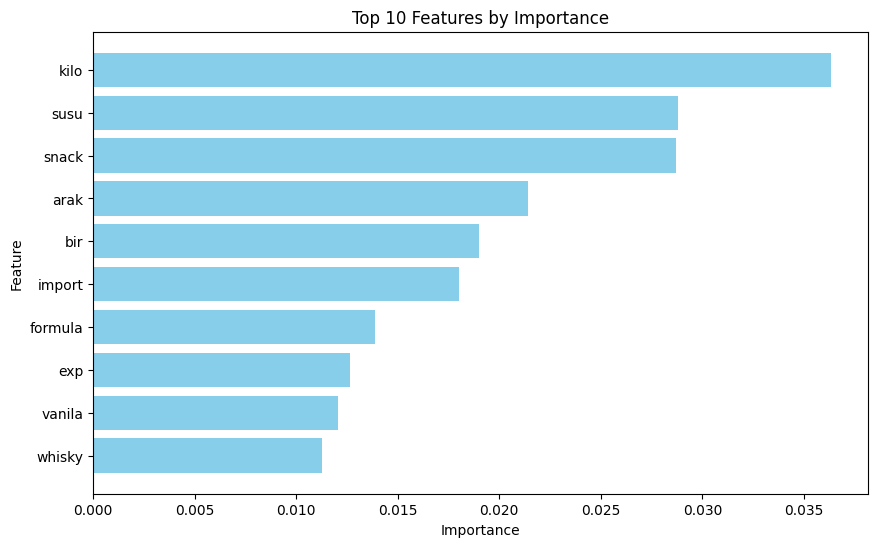

In [ ]:
# Get feature names (words or tokens)
feature_names = tfidf_vect.get_feature_names_out()

# Get feature importance values
feature_importance_rf = model_tf.feature_importances_

# Combine feature names and importance values
feature_importance_map = dict(zip(feature_names, feature_importance_rf))

# Sort feature importance map by values (importance)
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Extract top N features and importance values
top_features = [feature for feature, _ in sorted_features[:top_n]]
top_importance = [importance for _, importance in sorted_features[:top_n]]

# Plot top N features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Features by Importance'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

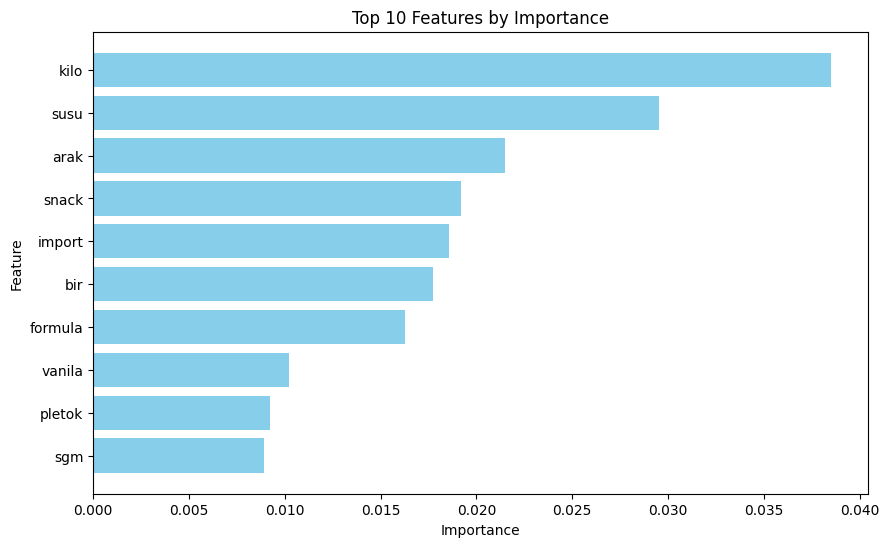

In [ ]:
# Get feature names (words or tokens)
feature_names = count_vect.get_feature_names_out()

# Get feature importance values
feature_importance_rf = model_oh.feature_importances_

# Combine feature names and importance values
feature_importance_map = dict(zip(feature_names, feature_importance_rf))

# Sort feature importance map by values (importance)
sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Extract top N features and importance values
top_features = [feature for feature, _ in sorted_features[:top_n]]
top_importance = [importance for _, importance in sorted_features[:top_n]]

# Plot top N features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Features by Importance'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#XGBoost Classifier

Model:  XGB_Count_Vectors
Model Parameter:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Precision on Test Data:  0.8269896193771626
Recall on Tes

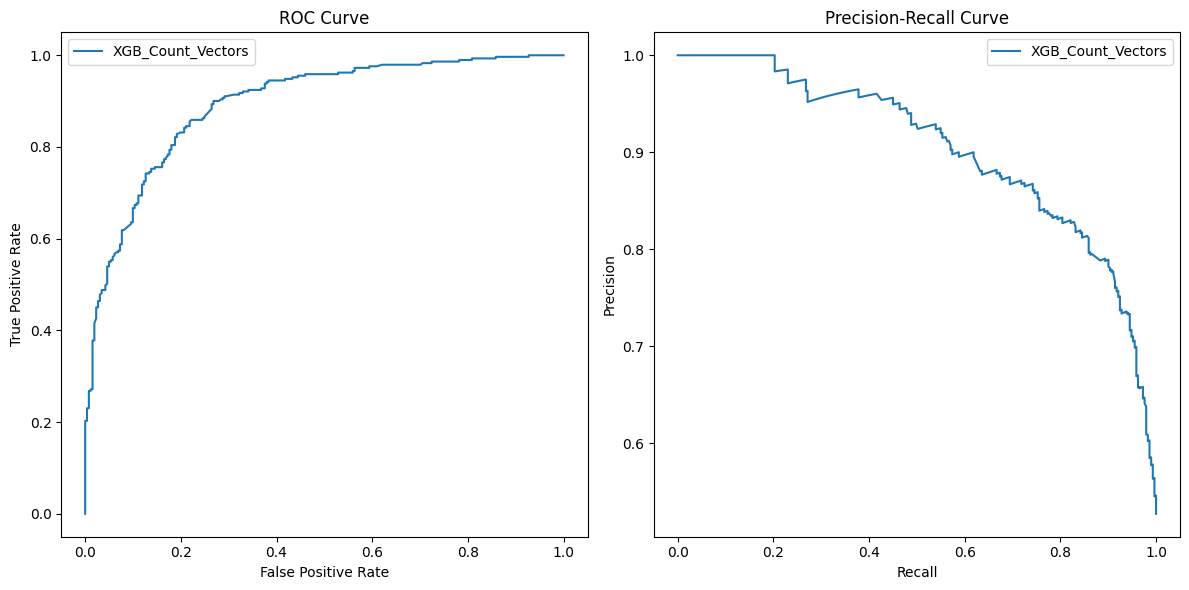

Model:  XGB_WordLevel_TF-IDF
Model Parameter:  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Precision on Test Data:  0.8206896551724138
Recall on 

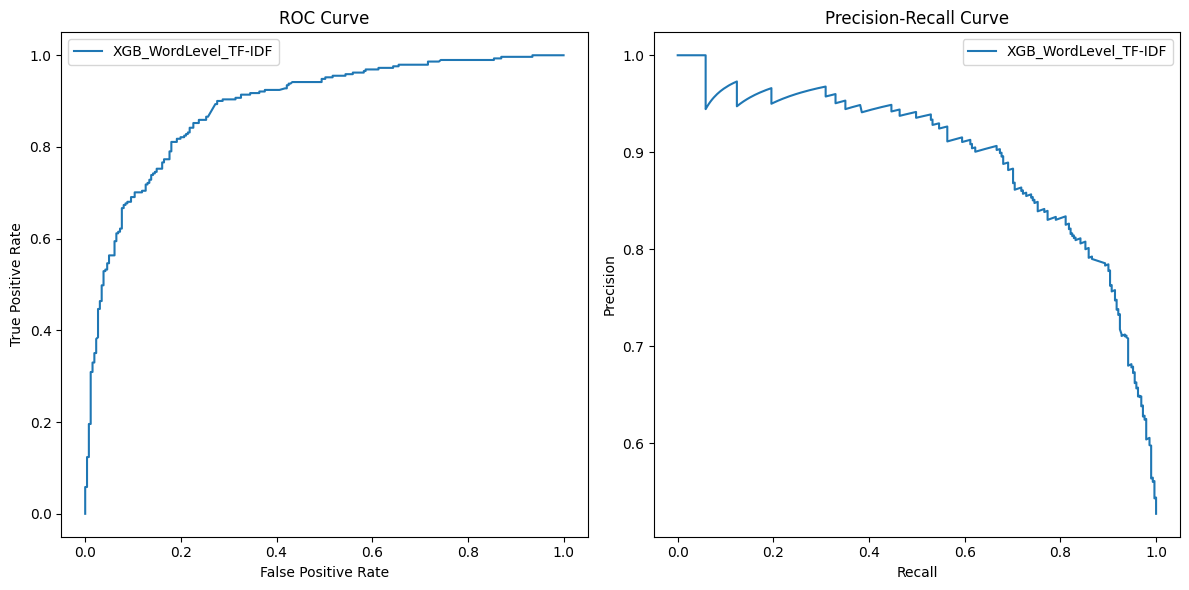

In [ ]:
if xgboost_classifier:
    model_oh = XGBClassifier(n_estimators=1000, subsample=0.8)
    model_oh.fit(xtrain_count, train_y)

    model_tf = XGBClassifier(n_estimators=1000, subsample=0.8)
    model_tf.fit(xtrain_tfidf, train_y)

    fit_params_oh = {'early_stopping_rounds': 10, 'eval_set': [(xvalid_count, valid_y)]}
    fit_params_tf = {'early_stopping_rounds': 10, 'eval_set': [(xvalid_tfidf, valid_y)]}

    dfs_to_concat = [
        report(model_oh, xtrain_count, train_y, xvalid_count, valid_y, name='XGB_Count_Vectors', cv=5, fit_params=fit_params_oh, dict_scoring=score_metrics),
        report(model_tf, xtrain_tfidf, train_y, xvalid_tfidf, valid_y, name='XGB_WordLevel_TF-IDF', cv=5, fit_params=fit_params_tf, dict_scoring=score_metrics)
      ]

    xgb_cv_results = pd.concat(dfs_to_concat)

    joblib.dump(model_oh, 'xgb_model_oh.joblib')
    joblib.dump(model_tf, 'xgb_model_tf.joblib')

In [ ]:
xgb_cv_results

,Model,data_count_cv1,data_count_cv2,data_count_cv3,data_count_cv4,data_count_cv5,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,score_time_cv3,score_time_cv4,score_time_cv5,score_time_mean,score_time_std,test_acc_cv1,test_acc_cv2,test_acc_cv3,test_acc_cv4,test_acc_cv5,test_acc_mean,test_acc_std,test_balanced_accuracy_cv1,test_balanced_accuracy_cv2,test_balanced_accuracy_cv3,test_balanced_accuracy_cv4,test_balanced_accuracy_cv5,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std,test_tp_cv1,test_tp_cv2,test_tp_cv3,test_tp_cv4,test_tp_cv5,test_tp_mean,test_tp_std,test_tn_cv1,test_tn_cv2,test_tn_cv3,test_tn_cv4,test_tn_cv5,test_tn_mean,test_tn_std,test_fp_cv1,test_fp_cv2,test_fp_cv3,test_fp_cv4,test_fp_cv5,test_fp_mean,test_fp_std,test_fn_cv1,test_fn_cv2,test_fn_cv3,test_fn_cv4,test_fn_cv5,test_fn_mean,test_fn_std,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std,Precision,Recall,F1 Score,ROC/AUC
0,XGB_Count_Vectors,442,442,441,441,441,5.629083,4.426695,4.684372,5.776483,3.482303,4.799787,0.840232,0.051703,0.02176,0.043786,0.034352,0.013836,0.033088,0.013867,0.848416,0.825792,0.795918,0.823129,0.85941,0.830533,0.022042,0.848525,0.829555,0.797936,0.822078,0.860061,0.831631,0.021562,0.865217,0.879464,0.842105,0.823529,0.908629,0.863789,0.029494,0.846809,0.797571,0.780488,0.8,0.802691,0.805512,0.022059,0.855914,0.836518,0.810127,0.811594,0.852381,0.833307,0.019463,199,197,192,168,179,187.0,11.781341,176,168,159,195,200,179.6,15.653754,31,27,36,36,18,29.6,6.711185,36,50,54,42,44,45.2,6.273755,0.848525,0.829555,0.797936,0.822078,0.860061,0.831631,0.021562,0.82699,0.821306,0.824138,0.892812
0,XGB_WordLevel_TF-IDF,442,442,441,441,441,4.431343,4.543634,2.754343,4.327686,3.063646,3.82413,0.756669,0.036316,0.020855,0.022601,0.046453,0.023171,0.029879,0.009955,0.830317,0.828054,0.807256,0.818594,0.8322,0.823284,0.00928,0.832079,0.830499,0.809694,0.818615,0.832949,0.824767,0.009147,0.866972,0.873362,0.854626,0.803738,0.88601,0.856942,0.028465,0.804255,0.809717,0.788618,0.819048,0.766816,0.797691,0.018327,0.834437,0.840336,0.820296,0.811321,0.822115,0.825701,0.010386,189,200,194,172,171,185.2,11.720068,178,166,162,189,196,178.2,12.998461,29,29,33,42,22,31.0,6.542171,46,47,52,38,52,47.0,5.138093,0.832079,0.830499,0.809694,0.818615,0.832949,0.824767,0.009147,0.82069,0.817869,0.819277,0.888323


#Results

In [ ]:
df_res = pd.concat([nb_cv_results, knn_cv_results, rf_cv_results, xgb_cv_results])

In [ ]:
df_res.to_csv('skripsi_model_selection_results.csv')

In [ ]:
df_res

,Model,data_count_cv1,data_count_cv2,data_count_cv3,data_count_cv4,data_count_cv5,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,score_time_cv3,score_time_cv4,score_time_cv5,score_time_mean,score_time_std,test_acc_cv1,test_acc_cv2,test_acc_cv3,test_acc_cv4,test_acc_cv5,test_acc_mean,test_acc_std,test_balanced_accuracy_cv1,test_balanced_accuracy_cv2,test_balanced_accuracy_cv3,test_balanced_accuracy_cv4,test_balanced_accuracy_cv5,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std,test_tp_cv1,test_tp_cv2,test_tp_cv3,test_tp_cv4,test_tp_cv5,test_tp_mean,test_tp_std,test_tn_cv1,test_tn_cv2,test_tn_cv3,test_tn_cv4,test_tn_cv5,test_tn_mean,test_tn_std,test_fp_cv1,test_fp_cv2,test_fp_cv3,test_fp_cv4,test_fp_cv5,test_fp_mean,test_fp_std,test_fn_cv1,test_fn_cv2,test_fn_cv3,test_fn_cv4,test_fn_cv5,test_fn_mean,test_fn_std,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std,Precision,Recall,F1 Score,ROC/AUC
0,NB_Count_Vectors,442,442,441,441,441,0.005901,0.005938,0.0046,0.005455,0.004422,0.005263,0.00064,0.019829,0.019736,0.019905,0.020712,0.014382,0.018913,0.002292,0.821267,0.852941,0.804989,0.827664,0.85941,0.833254,0.020227,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097,0.83913,0.861111,0.814961,0.799107,0.86758,0.836378,0.026232,0.821277,0.878543,0.841463,0.852381,0.852018,0.849136,0.01854,0.830108,0.869739,0.828,0.824885,0.859729,0.842492,0.018509,193,217,207,179,190,197.2,13.332667,170,160,148,186,189,170.6,15.486769,37,35,47,45,29,38.6,6.621178,42,30,39,31,33,35.0,4.690416,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097,0.814935,0.862543,0.838063,0.891015
0,NB_WordLevel_TF-IDF,442,442,441,441,441,0.01289,0.005479,0.004948,0.005229,0.004114,0.006532,0.003212,0.024231,0.020145,0.019819,0.019797,0.01237,0.019273,0.003836,0.816742,0.861991,0.811791,0.818594,0.866213,0.835066,0.023849,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143,0.82906,0.866142,0.814672,0.782609,0.862832,0.831063,0.031178,0.825532,0.890688,0.857724,0.857143,0.874439,0.861105,0.021659,0.827292,0.878244,0.835644,0.818182,0.868597,0.845592,0.023582,194,220,211,180,195,200.0,14.014278,167,161,147,181,187,168.6,14.277255,40,34,48,50,31,40.6,7.472617,41,27,35,30,28,32.2,5.192302,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143,0.808917,0.872852,0.839669,0.895768
0,kNN_Count_Vectors,442,442,441,441,441,0.002915,0.003622,0.006026,0.006436,0.002715,0.004343,0.001576,0.162054,0.135022,0.159241,0.134946,0.108392,0.139931,0.019524,0.764706,0.823529,0.809524,0.78458,0.85941,0.80835,0.032585,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756,0.729825,0.814126,0.824,0.742616,0.842553,0.790624,0.045529,0.885106,0.88664,0.837398,0.838095,0.887892,0.867026,0.023924,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966,208,219,206,176,198,201.4,14.361058,130,145,151,170,181,155.4,18.117395,77,50,44,61,37,53.8,14.019986,27,28,40,34,25,30.8,5.491812,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756,0.810458,0.852234,0.830821,0.899698
0,kNN_WordLevel_TF-IDF,442,442,441,441,441,0.007955,0.003655,0.002861,0.00272,0.00257,0.003952,0.002036,0.318857,0.265272,0.197531,0.178623,0.135565,0.21917,0.065062,0.832579,0.88009,0.809524,0.807256,0.868481,0.839586,0.029912,0.832768,0.878677,0.804816,0.809091,0.868567,0.838784,0.030167,0.851528,0.894309,0.818898,0.770563,0.876712,0.842402,0.043973,0.829787,0.890688,0.845528,0.847619,0.860987,0.854922,0.020442,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609,195,220,208,178,192,198

In [ ]:
df_cv_precision = df_res[['Model', 'test_prec_cv1',	'test_prec_cv2',	'test_prec_cv3',	'test_prec_cv4',	'test_prec_cv5',	'test_prec_mean', 'test_prec_std']]
df_cv_recall = df_res[['Model','test_recall_cv1',	'test_recall_cv2',	'test_recall_cv3',	'test_recall_cv4',	'test_recall_cv5',	'test_recall_mean', 'test_recall_std']]
df_cv_f1 = df_res[['Model','test_f1-score_cv1',	'test_f1-score_cv2',	'test_f1-score_cv3',	'test_f1-score_cv4',	'test_f1-score_cv5',	'test_f1-score_mean', 'test_f1-score_std']]
df_cv_roc_auc = df_res[['Model', 'test_roc_auc_cv1', 'test_roc_auc_cv2', 'test_roc_auc_cv3', 'test_roc_auc_cv4', 'test_roc_auc_cv5', 'test_roc_auc_mean', 'test_roc_auc_std']]

In [ ]:
df_cv_precision

,Model,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std
0,NB_Count_Vectors,0.83913,0.861111,0.814961,0.799107,0.86758,0.836378,0.026232
0,NB_WordLevel_TF-IDF,0.82906,0.866142,0.814672,0.782609,0.862832,0.831063,0.031178
0,kNN_Count_Vectors,0.729825,0.814126,0.824,0.742616,0.842553,0.790624,0.045529
0,kNN_WordLevel_TF-IDF,0.851528,0.894309,0.818898,0.770563,0.876712,0.842402,0.043973
0,RF_Count_Vectors,0.882096,0.899563,0.857143,0.798206,0.899543,0.86731,0.037886
0,RF_WordLevel_TF-IDF,0.872807,0.914414,0.851064,0.824885,0.917073,0.876049,0.035798
0,XGB_Count_Vectors,0.865217,0.879464,0.842105,0.823529,0.908629,0.863789,0.029494
0,XGB_WordLevel_TF-IDF,0.866972,0.873362,0.854626,0.803738,0.88601,0.856942,0.028465


In [ ]:
df_cv_recall

,Model,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std
0,NB_Count_Vectors,0.821277,0.878543,0.841463,0.852381,0.852018,0.849136,0.01854
0,NB_WordLevel_TF-IDF,0.825532,0.890688,0.857724,0.857143,0.874439,0.861105,0.021659
0,kNN_Count_Vectors,0.885106,0.88664,0.837398,0.838095,0.887892,0.867026,0.023924
0,kNN_WordLevel_TF-IDF,0.829787,0.890688,0.845528,0.847619,0.860987,0.854922,0.020442
0,RF_Count_Vectors,0.859574,0.834008,0.829268,0.847619,0.883408,0.850776,0.019473
0,RF_WordLevel_TF-IDF,0.846809,0.821862,0.813008,0.852381,0.843049,0.835422,0.015243
0,XGB_Count_Vectors,0.846809,0.797571,0.780488,0.8,0.802691,0.805512,0.022059
0,XGB_WordLevel_TF-IDF,0.804255,0.809717,0.788618,0.819048,0.766816,0.797691,0.018327


In [ ]:
df_cv_f1

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,NB_Count_Vectors,0.830108,0.869739,0.828,0.824885,0.859729,0.842492,0.018509
0,NB_WordLevel_TF-IDF,0.827292,0.878244,0.835644,0.818182,0.868597,0.845592,0.023582
0,kNN_Count_Vectors,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966
0,kNN_WordLevel_TF-IDF,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609
0,RF_Count_Vectors,0.87069,0.865546,0.842975,0.822171,0.891403,0.858557,0.02384
0,RF_WordLevel_TF-IDF,0.859611,0.865672,0.831601,0.838407,0.878505,0.854759,0.017379
0,XGB_Count_Vectors,0.855914,0.836518,0.810127,0.811594,0.852381,0.833307,0.019463
0,XGB_WordLevel_TF-IDF,0.834437,0.840336,0.820296,0.811321,0.822115,0.825701,0.010386


In [ ]:
df_cv_roc_auc

,Model,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std
0,NB_Count_Vectors,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097
0,NB_WordLevel_TF-IDF,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143
0,kNN_Count_Vectors,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756
0,kNN_WordLevel_TF-IDF,0.832768,0.878677,0.804816,0.809091,0.868567,0.838784,0.030167
0,RF_Count_Vectors,0.86457,0.85803,0.827455,0.826407,0.891245,0.853541,0.024414
0,RF_WordLevel_TF-IDF,0.853356,0.862213,0.81676,0.843939,0.882534,0.851761,0.021656
0,XGB_Count_Vectors,0.848525,0.829555,0.797936,0.822078,0.860061,0.831631,0.021562
0,XGB_WordLevel_TF-IDF,0.832079,0.830499,0.809694,0.818615,0.832949,0.824767,0.009147


In [ ]:
df_test_performance = df_res[['Model', 'Precision', 'Recall', 'ROC/AUC', 'F1 Score']]

In [ ]:
df_test_performance.sort_values(by='F1 Score', ascending=False, inplace=True)

<ipython-input-84-6d9cf8c597f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_performance.sort_values(by='F1 Score', ascending=False, inplace=True)


In [ ]:
df_test_performance['f1_uplift_lag1_percent'] = ((df_test_performance['F1 Score'].diff()) / df_test_performance['F1 Score'].shift(1)) * 100
df_test_performance.fillna(0, inplace=True)
df_test_performance

<ipython-input-85-f39a5f4111a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_performance['f1_uplift_lag1_percent'] = ((df_test_performance['F1 Score'].diff()) / df_test_performance['F1 Score'].shift(1)) * 100
<ipython-input-85-f39a5f4111a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_performance.fillna(0, inplace=True)


,Model,Precision,Recall,ROC/AUC,F1 Score,f1_uplift_lag1_percent
0,RF_WordLevel_TF-IDF,0.860627,0.848797,0.916736,0.854671,0.000000
0,RF_Count_Vectors,0.863158,0.845361,0.920877,0.854167,-0.059042
0,NB_WordLevel_TF-IDF,0.808917,0.872852,0.895768,0.839669,-1.697238
0,NB_Count_Vectors,0.814935,0.862543,0.891015,0.838063,-0.191264
0,kNN_WordLevel_TF-IDF,0.816993,0.859107,0.902371,0.837521,-0.064733
0,kNN_Count_Vectors,0.810458,0.852234,0.899698,0.830821,-0.800000
0,XGB_Count_Vectors,0.82699,0.821306,0.892812,0.824138,-0.804366
0,XGB_WordLevel_TF-IDF,0.82069,0.817869,0.888323,0.819277,-0.589807


In [ ]:
df_test_performance[['Model','Precision', 'Recall', 'F1 Score']].sort_values(by='F1 Score', ascending=False)[:1]

,Model,Precision,Recall,F1 Score
0,RF_WordLevel_TF-IDF,0.860627,0.848797,0.854671


# Test Data Results

### ROC

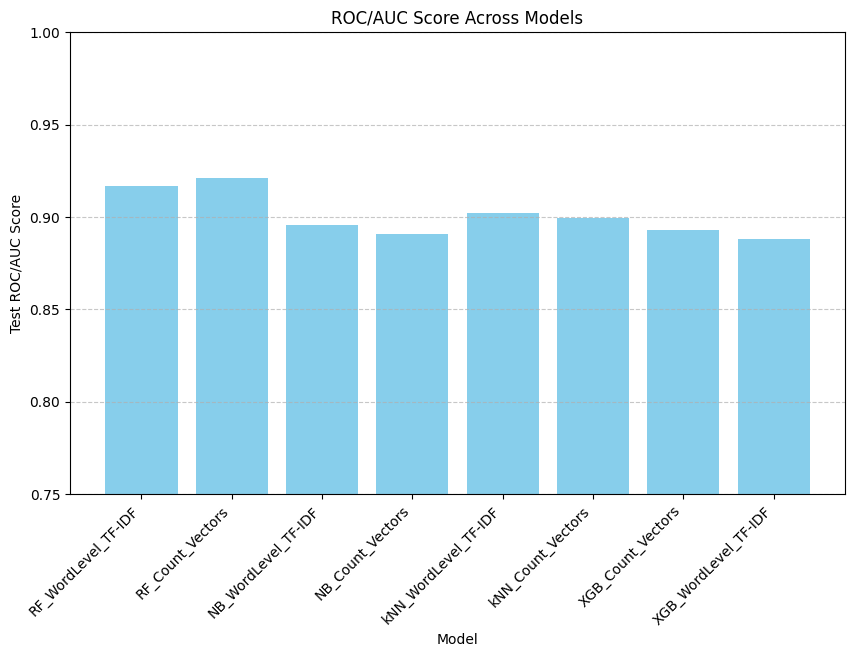

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_test_performance['Model'].to_list()
test_roc_auc_mean = df_test_performance['ROC/AUC'].to_list()

plt.bar(model_names, test_roc_auc_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test ROC/AUC Score')
plt.title('ROC/AUC Score Across Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 1)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

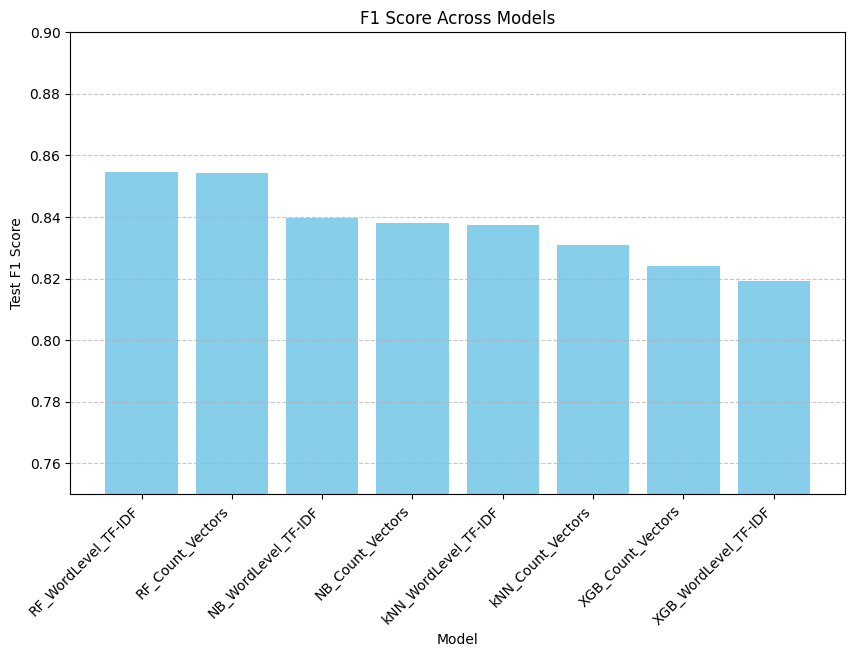

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_test_performance['Model'].to_list()
test_roc_auc_mean = df_test_performance['F1 Score'].to_list()

plt.bar(model_names, test_roc_auc_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test F1 Score')
plt.title('F1 Score Across Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 0.9)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Recall

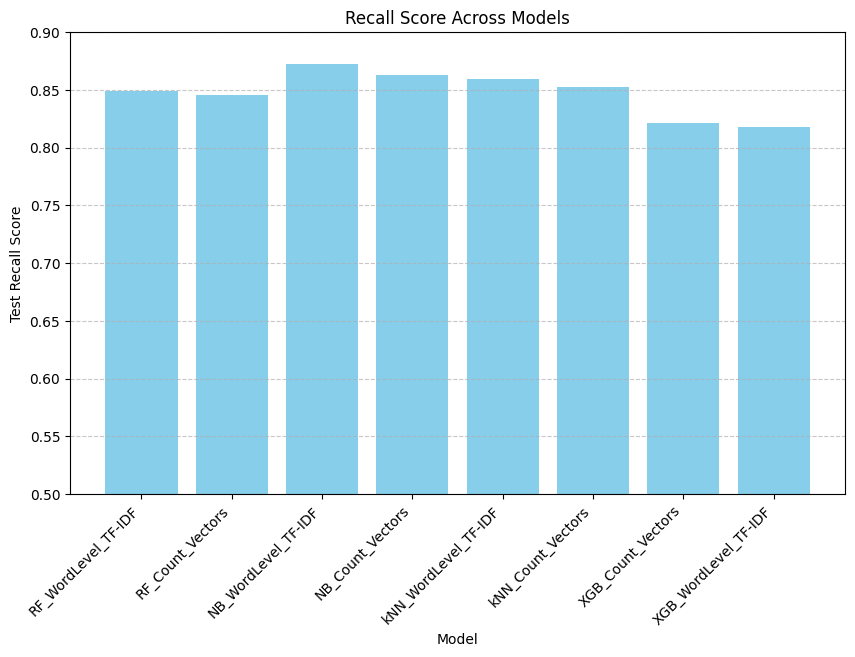

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_test_performance['Model'].to_list()
test_roc_auc_mean = df_test_performance['Recall'].to_list()

plt.bar(model_names, test_roc_auc_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Recall Score')
plt.title('Recall Score Across Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 0.9)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Precision

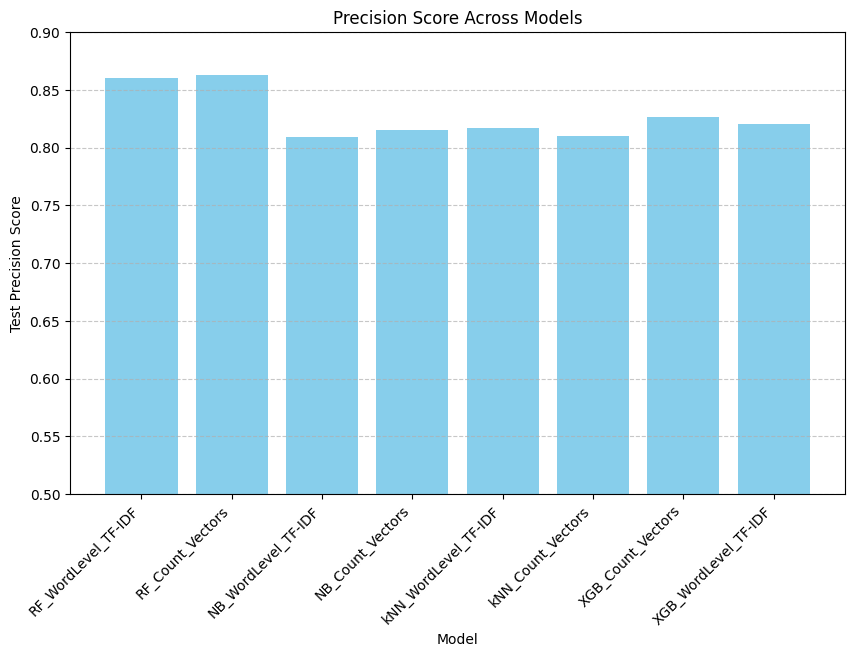

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_test_performance['Model'].to_list()
test_roc_auc_mean = df_test_performance['Precision'].to_list()

plt.bar(model_names, test_roc_auc_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Precision Score')
plt.title('Precision Score Across Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 0.9)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# CV Performance

In [ ]:
df_cv_f1

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,NB_Count_Vectors,0.830108,0.869739,0.828,0.824885,0.859729,0.842492,0.018509
0,NB_WordLevel_TF-IDF,0.827292,0.878244,0.835644,0.818182,0.868597,0.845592,0.023582
0,kNN_Count_Vectors,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966
0,kNN_WordLevel_TF-IDF,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609
0,RF_Count_Vectors,0.87069,0.865546,0.842975,0.822171,0.891403,0.858557,0.02384
0,RF_WordLevel_TF-IDF,0.859611,0.865672,0.831601,0.838407,0.878505,0.854759,0.017379
0,XGB_Count_Vectors,0.855914,0.836518,0.810127,0.811594,0.852381,0.833307,0.019463
0,XGB_WordLevel_TF-IDF,0.834437,0.840336,0.820296,0.811321,0.822115,0.825701,0.010386


<Figure size 1000x600 with 0 Axes>

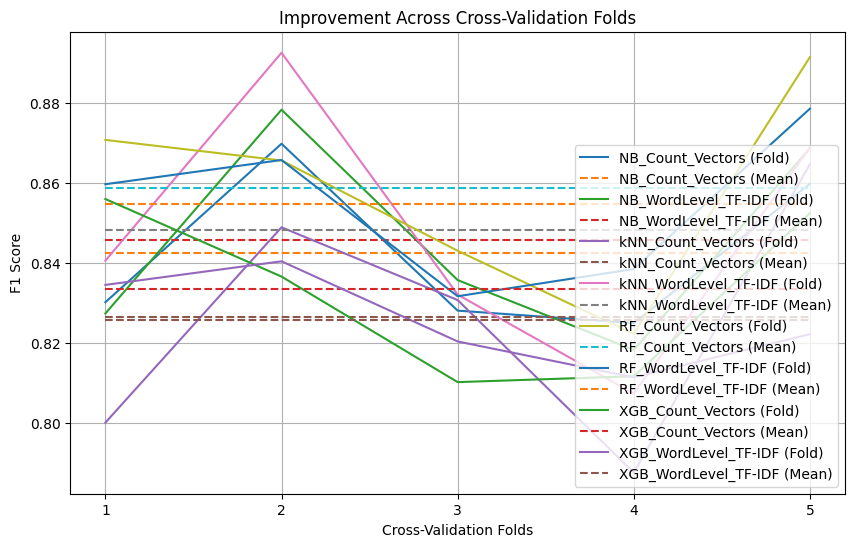

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'].to_list()
test_roc_auc_cv1 = df_cv_f1['test_f1-score_cv1'].to_list()
test_roc_auc_cv2 = df_cv_f1['test_f1-score_cv2'].to_list()
test_roc_auc_cv3 = df_cv_f1['test_f1-score_cv3'].to_list()
test_roc_auc_cv4 = df_cv_f1['test_f1-score_cv4'].to_list()
test_roc_auc_cv5 = df_cv_f1['test_f1-score_cv5'].to_list()
test_roc_auc_mean = df_cv_f1['test_f1-score_mean'].to_list()

# Plotting
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--', label=f'{model} (Mean)')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('F1 Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_f1.sort_values(by=['test_f1-score_mean'], ascending=False)

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,RF_Count_Vectors,0.87069,0.865546,0.842975,0.822171,0.891403,0.858557,0.02384
0,RF_WordLevel_TF-IDF,0.859611,0.865672,0.831601,0.838407,0.878505,0.854759,0.017379
0,kNN_WordLevel_TF-IDF,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609
0,NB_WordLevel_TF-IDF,0.827292,0.878244,0.835644,0.818182,0.868597,0.845592,0.023582
0,NB_Count_Vectors,0.830108,0.869739,0.828,0.824885,0.859729,0.842492,0.018509
0,XGB_Count_Vectors,0.855914,0.836518,0.810127,0.811594,0.852381,0.833307,0.019463
0,kNN_Count_Vectors,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966
0,XGB_WordLevel_TF-IDF,0.834437,0.840336,0.820296,0.811321,0.822115,0.825701,0.010386


<Figure size 1000x600 with 0 Axes>

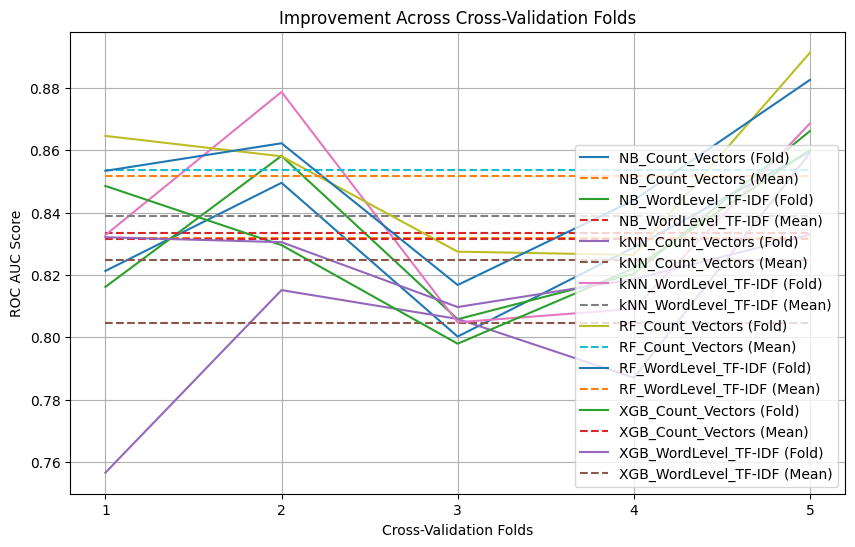

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'].to_list()
test_roc_auc_cv1 = df_cv_roc_auc['test_roc_auc_cv1'].to_list()
test_roc_auc_cv2 = df_cv_roc_auc['test_roc_auc_cv2'].to_list()
test_roc_auc_cv3 = df_cv_roc_auc['test_roc_auc_cv3'].to_list()
test_roc_auc_cv4 = df_cv_roc_auc['test_roc_auc_cv4'].to_list()
test_roc_auc_cv5 = df_cv_roc_auc['test_roc_auc_cv5'].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'].to_list()

# Plotting
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--', label=f'{model} (Mean)')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('ROC AUC Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

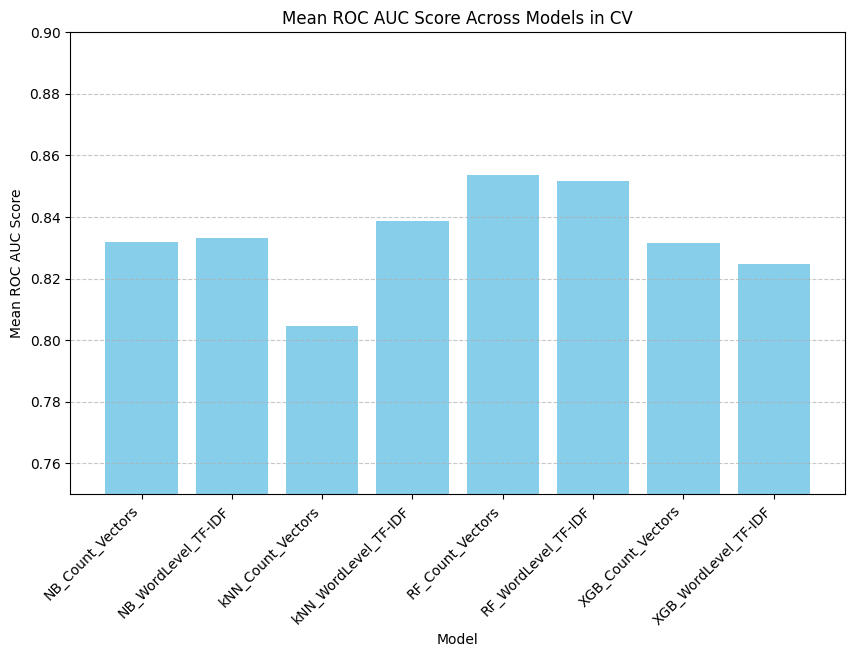

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'].to_list()

plt.bar(model_names, test_roc_auc_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean ROC AUC Score')
plt.title('Mean ROC AUC Score Across Models in CV')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 0.90)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

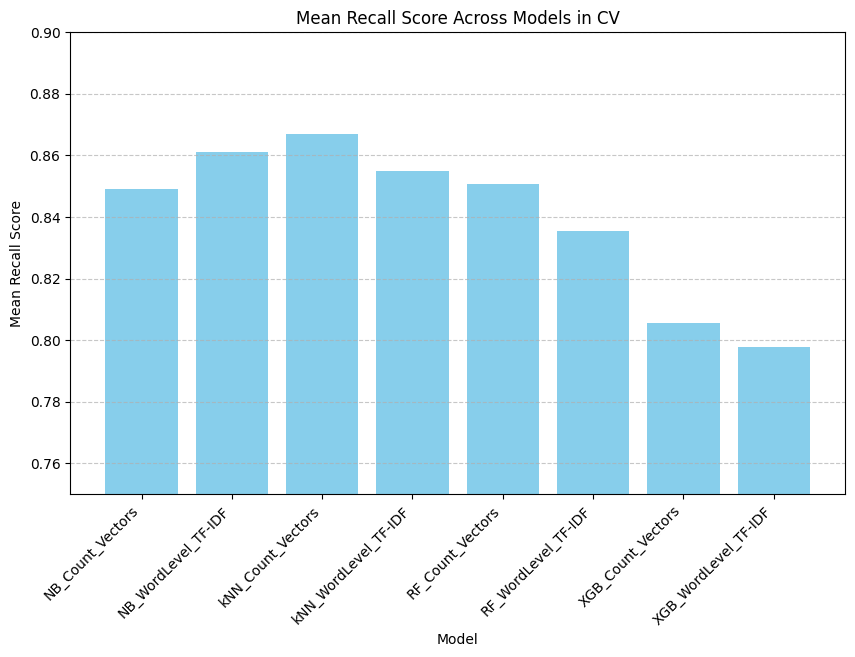

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_recall['Model'].to_list()
test_recall_mean = df_cv_recall['test_recall_mean'].to_list()

plt.bar(model_names, test_recall_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Recall Score')
plt.title('Mean Recall Score Across Models in CV')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 0.90)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

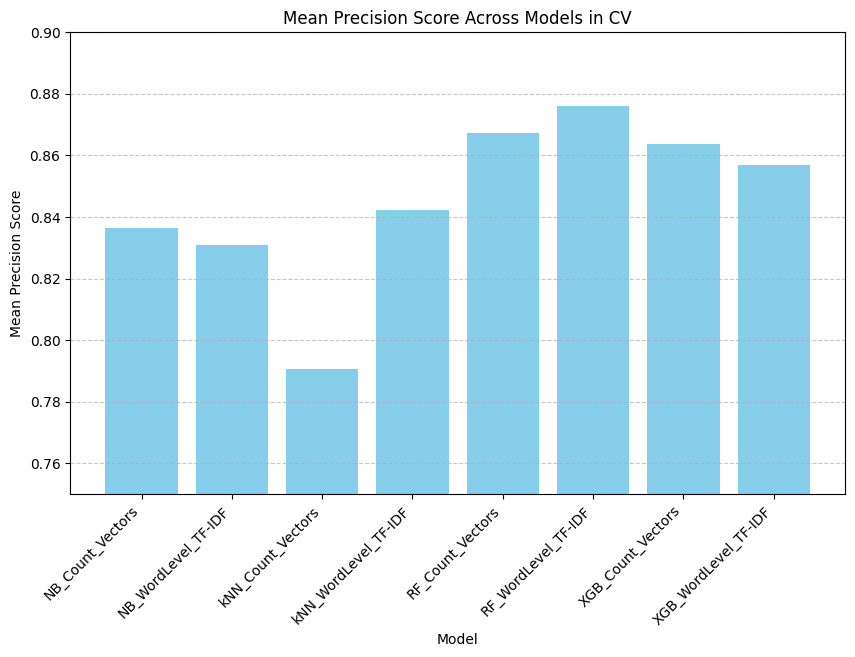

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_precision['Model'].to_list()
test_precision_mean = df_cv_precision['test_prec_mean'].to_list()

plt.bar(model_names, test_precision_mean, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Precision Score')
plt.title('Mean Precision Score Across Models in CV')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.75, 0.90)  # Adjust the y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Naive Bayes

### F1

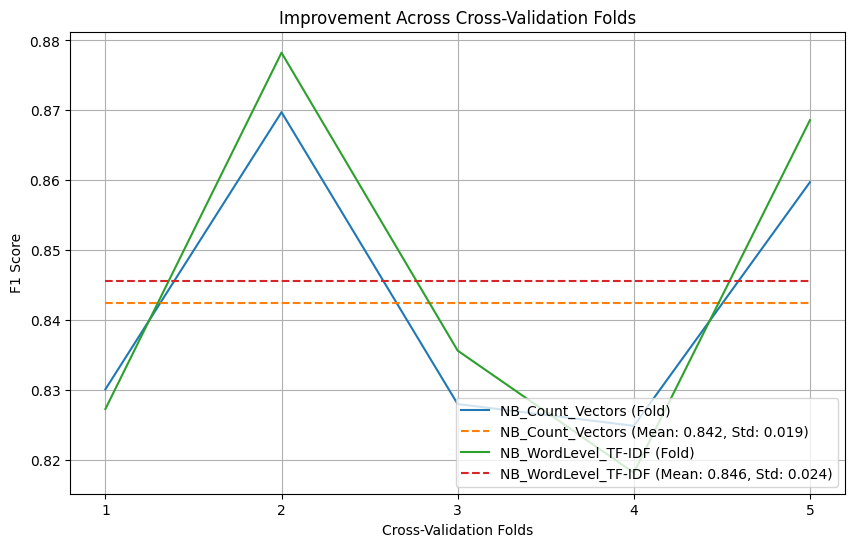

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][:2].to_list()
test_roc_auc_cv1 = df_cv_f1['test_f1-score_cv1'][:2].to_list()
test_roc_auc_cv2 = df_cv_f1['test_f1-score_cv2'][:2].to_list()
test_roc_auc_cv3 = df_cv_f1['test_f1-score_cv3'][:2].to_list()
test_roc_auc_cv4 = df_cv_f1['test_f1-score_cv4'][:2].to_list()
test_roc_auc_cv5 = df_cv_f1['test_f1-score_cv5'][:2].to_list()
test_roc_auc_mean = df_cv_f1['test_f1-score_mean'][:2].to_list()
test_roc_auc_std = df_cv_f1['test_f1-score_std'][:2].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('F1 Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### ROC

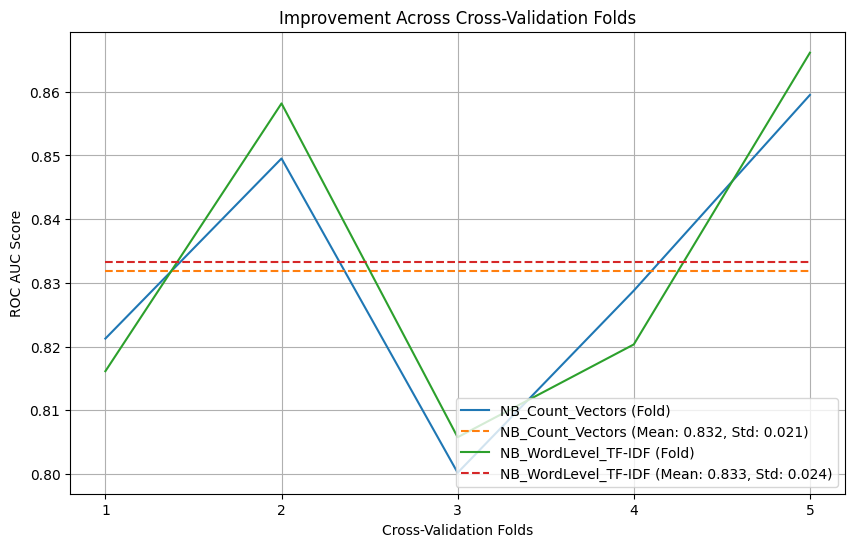

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][:2].to_list()
test_roc_auc_cv1 = df_cv_roc_auc['test_roc_auc_cv1'][:2].to_list()
test_roc_auc_cv2 = df_cv_roc_auc['test_roc_auc_cv2'][:2].to_list()
test_roc_auc_cv3 = df_cv_roc_auc['test_roc_auc_cv3'][:2].to_list()
test_roc_auc_cv4 = df_cv_roc_auc['test_roc_auc_cv4'][:2].to_list()
test_roc_auc_cv5 = df_cv_roc_auc['test_roc_auc_cv5'][:2].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'][:2].to_list()
test_roc_auc_std = df_cv_roc_auc['test_roc_auc_std'][:2].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('ROC AUC Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_roc_auc[:2]

,Model,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std
0,NB_Count_Vectors,0.821266,0.849528,0.800219,0.828788,0.859495,0.831859,0.02097
0,NB_WordLevel_TF-IDF,0.816148,0.858165,0.805785,0.820346,0.866119,0.833312,0.024143


### Recall

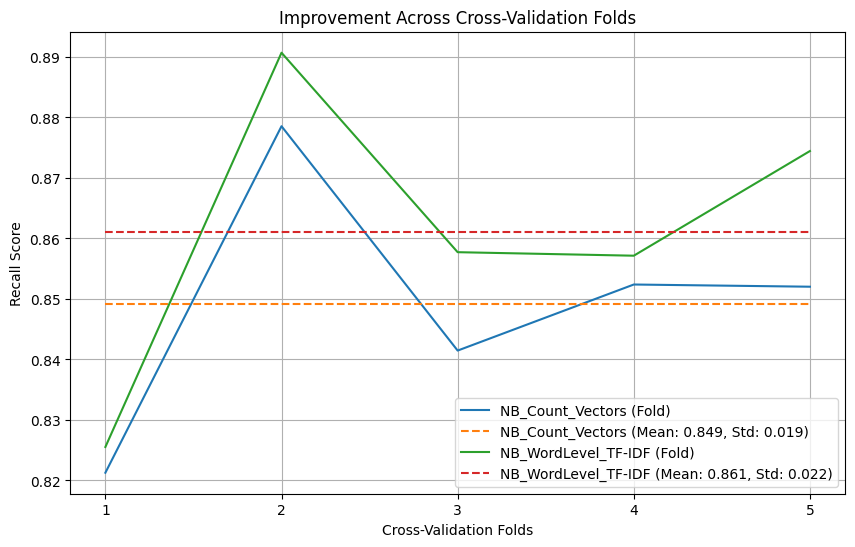

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_recall['Model'][:2].to_list()
test_roc_auc_cv1 = df_cv_recall['test_recall_cv1'][:2].to_list()
test_roc_auc_cv2 = df_cv_recall['test_recall_cv2'][:2].to_list()
test_roc_auc_cv3 = df_cv_recall['test_recall_cv3'][:2].to_list()
test_roc_auc_cv4 = df_cv_recall['test_recall_cv4'][:2].to_list()
test_roc_auc_cv5 = df_cv_recall['test_recall_cv5'][:2].to_list()
test_roc_auc_mean = df_cv_recall['test_recall_mean'][:2].to_list()
test_roc_auc_std = df_cv_recall['test_recall_std'][:2].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Recall Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_recall[:2]

,Model,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std
0,NB_Count_Vectors,0.821277,0.878543,0.841463,0.852381,0.852018,0.849136,0.01854
0,NB_WordLevel_TF-IDF,0.825532,0.890688,0.857724,0.857143,0.874439,0.861105,0.021659


### Precision

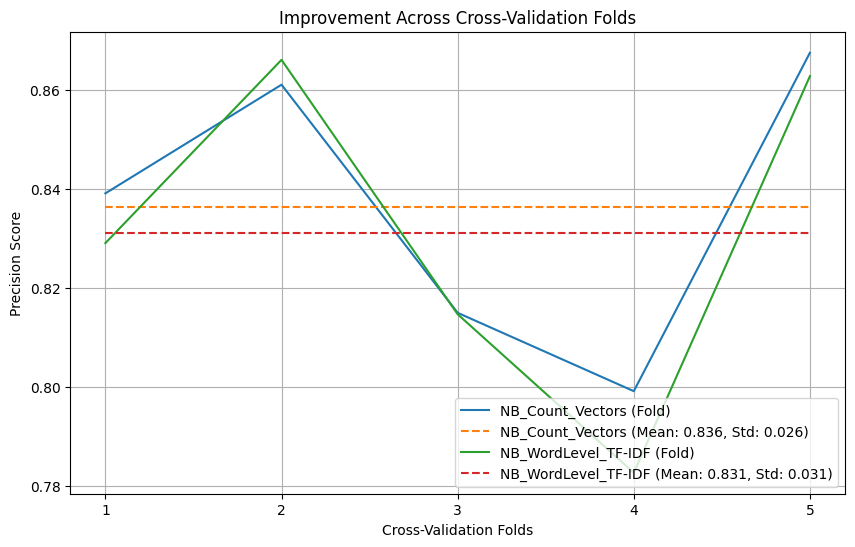

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_precision['Model'][:2].to_list()
test_roc_auc_cv1 = df_cv_precision['test_prec_cv1'][:2].to_list()
test_roc_auc_cv2 = df_cv_precision['test_prec_cv2'][:2].to_list()
test_roc_auc_cv3 = df_cv_precision['test_prec_cv3'][:2].to_list()
test_roc_auc_cv4 = df_cv_precision['test_prec_cv4'][:2].to_list()
test_roc_auc_cv5 = df_cv_precision['test_prec_cv5'][:2].to_list()
test_roc_auc_mean = df_cv_precision['test_prec_mean'][:2].to_list()
test_roc_auc_std = df_cv_precision['test_prec_std'][:2].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Precision Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
0.836/0.828-1

0.009661835748792313

In [ ]:
0.026/0.022-1

0.18181818181818188

In [ ]:
df_cv_precision[:2]

,Model,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std
0,NB_Count_Vectors,0.83913,0.861111,0.814961,0.799107,0.86758,0.836378,0.026232
0,NB_WordLevel_TF-IDF,0.82906,0.866142,0.814672,0.782609,0.862832,0.831063,0.031178


## KNN

### F1

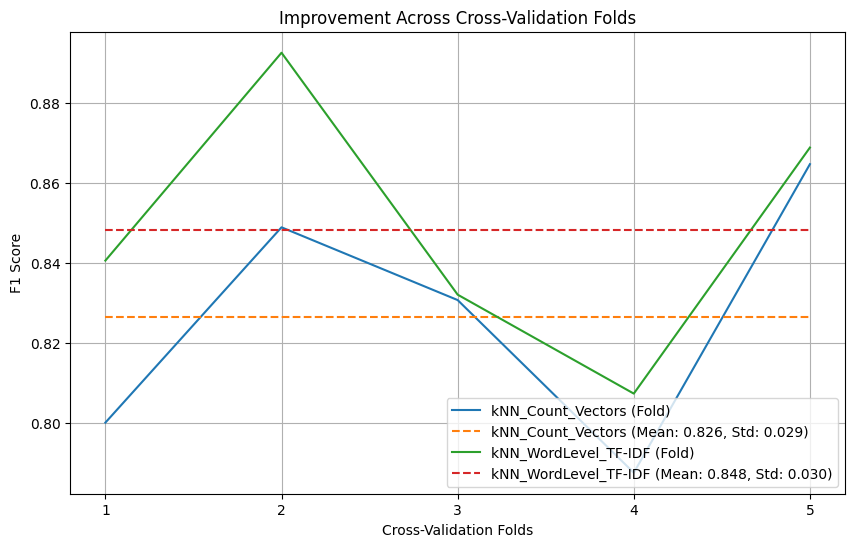

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][2:4].to_list()
test_roc_auc_cv1 = df_cv_f1['test_f1-score_cv1'][2:4].to_list()
test_roc_auc_cv2 = df_cv_f1['test_f1-score_cv2'][2:4].to_list()
test_roc_auc_cv3 = df_cv_f1['test_f1-score_cv3'][2:4].to_list()
test_roc_auc_cv4 = df_cv_f1['test_f1-score_cv4'][2:4].to_list()
test_roc_auc_cv5 = df_cv_f1['test_f1-score_cv5'][2:4].to_list()
test_roc_auc_mean = df_cv_f1['test_f1-score_mean'][2:4].to_list()
test_roc_auc_std = df_cv_f1['test_f1-score_std'][2:4].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('F1 Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_f1[2:4]

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,kNN_Count_Vectors,0.8,0.848837,0.830645,0.787472,0.864629,0.826317,0.028966
0,kNN_WordLevel_TF-IDF,0.840517,0.892495,0.832,0.807256,0.868778,0.848209,0.029609


### ROC

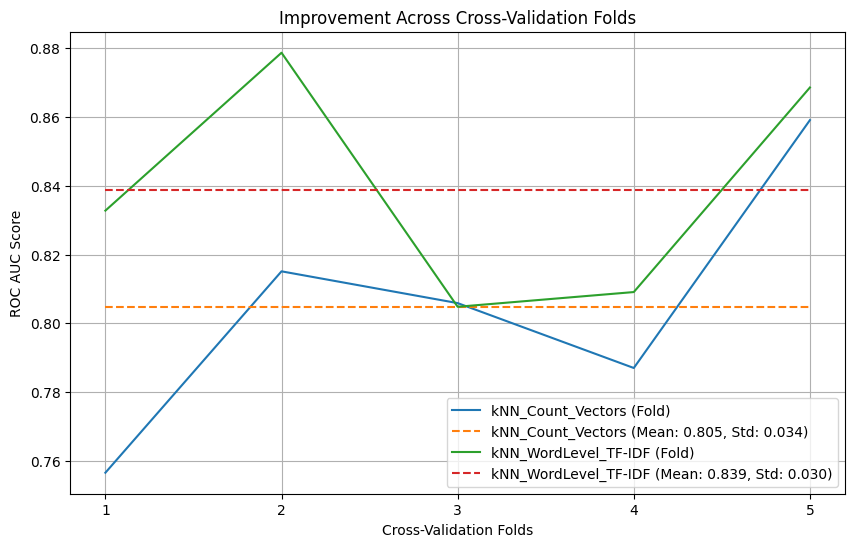

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][2:4].to_list()
test_roc_auc_cv1 = df_cv_roc_auc['test_roc_auc_cv1'][2:4].to_list()
test_roc_auc_cv2 = df_cv_roc_auc['test_roc_auc_cv2'][2:4].to_list()
test_roc_auc_cv3 = df_cv_roc_auc['test_roc_auc_cv3'][2:4].to_list()
test_roc_auc_cv4 = df_cv_roc_auc['test_roc_auc_cv4'][2:4].to_list()
test_roc_auc_cv5 = df_cv_roc_auc['test_roc_auc_cv5'][2:4].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'][2:4].to_list()
test_roc_auc_std = df_cv_roc_auc['test_roc_auc_std'][2:4].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('ROC AUC Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_roc_auc[2:4]

,Model,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std
0,kNN_Count_Vectors,0.756563,0.815115,0.805879,0.787013,0.859084,0.804731,0.033756
0,kNN_WordLevel_TF-IDF,0.832768,0.878677,0.804816,0.809091,0.868567,0.838784,0.030167


### Recall

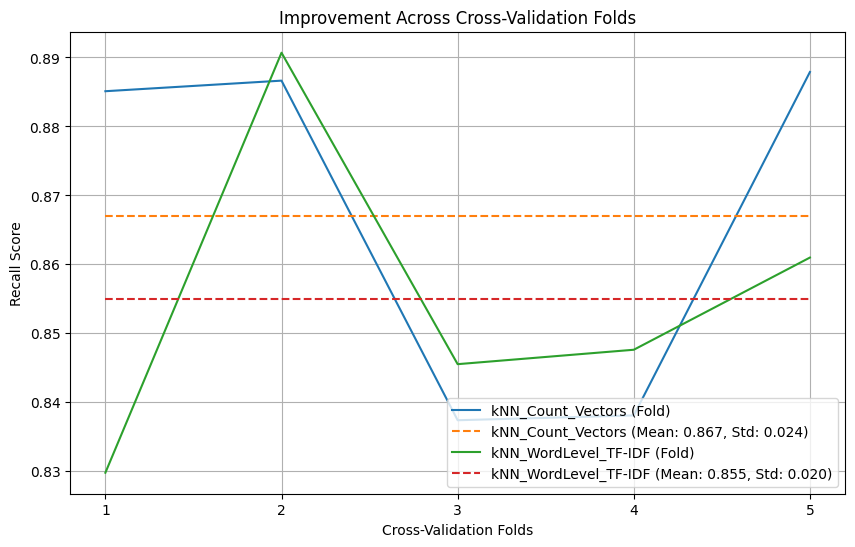

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_recall['Model'][2:4].to_list()
test_roc_auc_cv1 = df_cv_recall['test_recall_cv1'][2:4].to_list()
test_roc_auc_cv2 = df_cv_recall['test_recall_cv2'][2:4].to_list()
test_roc_auc_cv3 = df_cv_recall['test_recall_cv3'][2:4].to_list()
test_roc_auc_cv4 = df_cv_recall['test_recall_cv4'][2:4].to_list()
test_roc_auc_cv5 = df_cv_recall['test_recall_cv5'][2:4].to_list()
test_roc_auc_mean = df_cv_recall['test_recall_mean'][2:4].to_list()
test_roc_auc_std = df_cv_recall['test_recall_std'][2:4].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Recall Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_recall[2:4]

,Model,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std
0,kNN_Count_Vectors,0.885106,0.88664,0.837398,0.838095,0.887892,0.867026,0.023924
0,kNN_WordLevel_TF-IDF,0.829787,0.890688,0.845528,0.847619,0.860987,0.854922,0.020442


### Precision

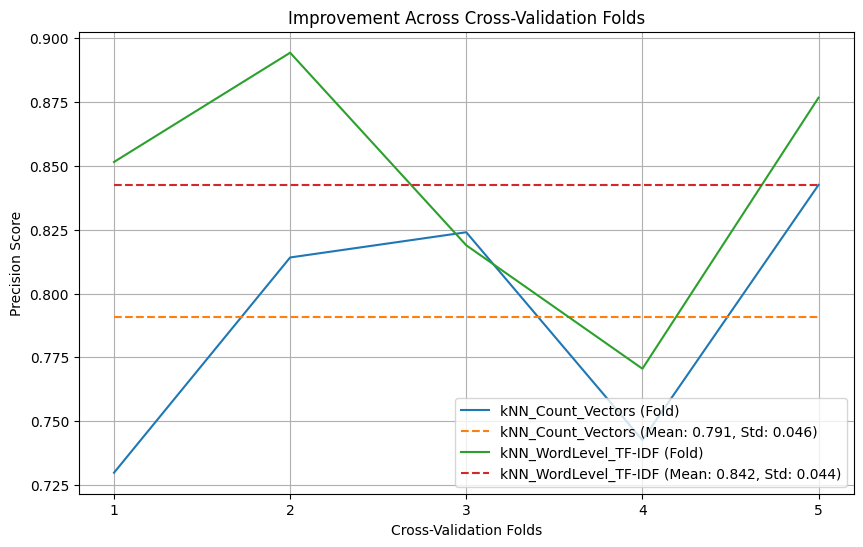

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_precision['Model'][2:4].to_list()
test_roc_auc_cv1 = df_cv_precision['test_prec_cv1'][2:4].to_list()
test_roc_auc_cv2 = df_cv_precision['test_prec_cv2'][2:4].to_list()
test_roc_auc_cv3 = df_cv_precision['test_prec_cv3'][2:4].to_list()
test_roc_auc_cv4 = df_cv_precision['test_prec_cv4'][2:4].to_list()
test_roc_auc_cv5 = df_cv_precision['test_prec_cv5'][2:4].to_list()
test_roc_auc_mean = df_cv_precision['test_prec_mean'][2:4].to_list()
test_roc_auc_std = df_cv_precision['test_prec_std'][2:4].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Precision Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_precision[2:4]

,Model,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std
0,kNN_Count_Vectors,0.729825,0.814126,0.824,0.742616,0.842553,0.790624,0.045529
0,kNN_WordLevel_TF-IDF,0.851528,0.894309,0.818898,0.770563,0.876712,0.842402,0.043973


## Random Forest

### F1

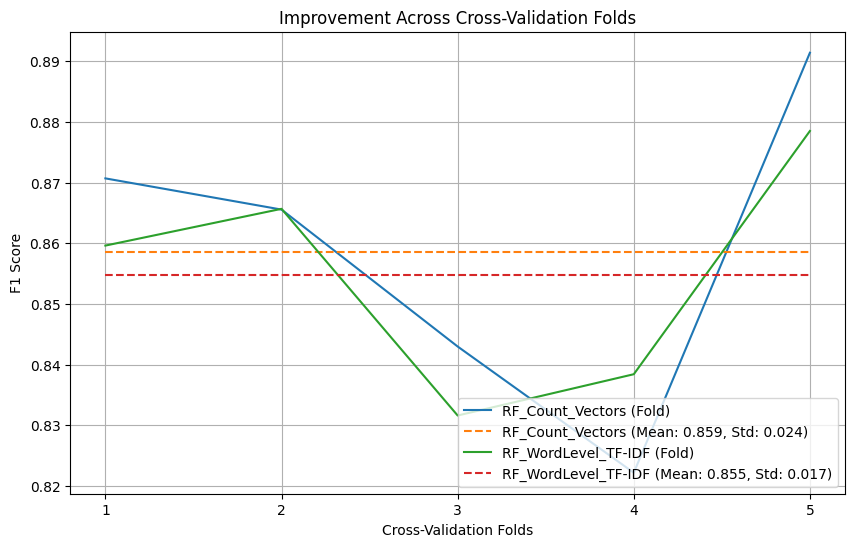

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][4:6].to_list()
test_roc_auc_cv1 = df_cv_f1['test_f1-score_cv1'][4:6].to_list()
test_roc_auc_cv2 = df_cv_f1['test_f1-score_cv2'][4:6].to_list()
test_roc_auc_cv3 = df_cv_f1['test_f1-score_cv3'][4:6].to_list()
test_roc_auc_cv4 = df_cv_f1['test_f1-score_cv4'][4:6].to_list()
test_roc_auc_cv5 = df_cv_f1['test_f1-score_cv5'][4:6].to_list()
test_roc_auc_mean = df_cv_f1['test_f1-score_mean'][4:6].to_list()
test_roc_auc_std = df_cv_f1['test_f1-score_std'][4:6].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('F1 Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_f1[4:6]

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,RF_Count_Vectors,0.87069,0.865546,0.842975,0.822171,0.891403,0.858557,0.02384
0,RF_WordLevel_TF-IDF,0.859611,0.865672,0.831601,0.838407,0.878505,0.854759,0.017379


### ROC

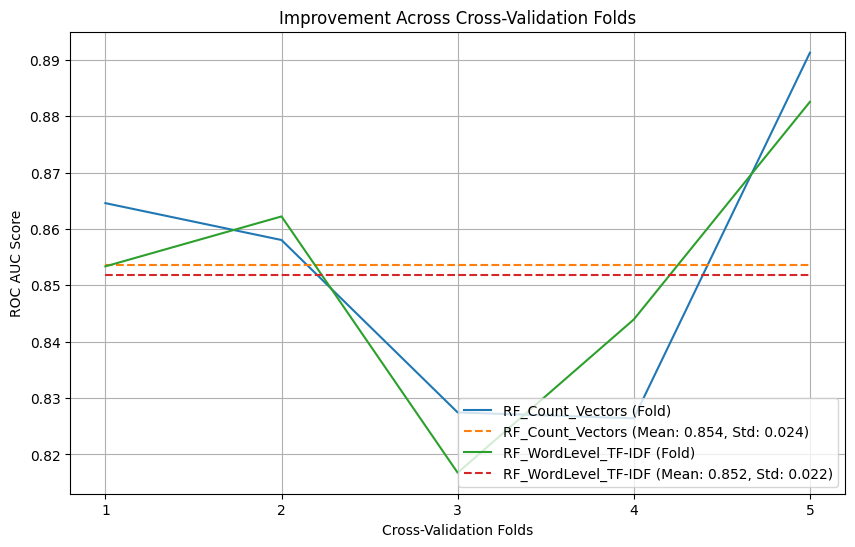

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][4:6].to_list()
test_roc_auc_cv1 = df_cv_roc_auc['test_roc_auc_cv1'][4:6].to_list()
test_roc_auc_cv2 = df_cv_roc_auc['test_roc_auc_cv2'][4:6].to_list()
test_roc_auc_cv3 = df_cv_roc_auc['test_roc_auc_cv3'][4:6].to_list()
test_roc_auc_cv4 = df_cv_roc_auc['test_roc_auc_cv4'][4:6].to_list()
test_roc_auc_cv5 = df_cv_roc_auc['test_roc_auc_cv5'][4:6].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'][4:6].to_list()
test_roc_auc_std = df_cv_roc_auc['test_roc_auc_std'][4:6].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('ROC AUC Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_roc_auc[4:6]

,Model,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std
0,RF_Count_Vectors,0.86457,0.85803,0.827455,0.826407,0.891245,0.853541,0.024414
0,RF_WordLevel_TF-IDF,0.853356,0.862213,0.81676,0.843939,0.882534,0.851761,0.021656


### Recall

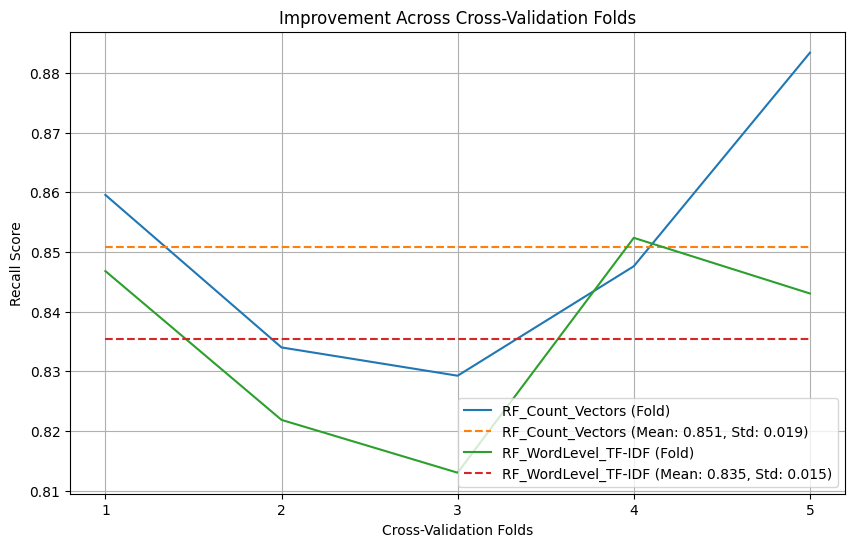

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_recall['Model'][4:6].to_list()
test_roc_auc_cv1 = df_cv_recall['test_recall_cv1'][4:6].to_list()
test_roc_auc_cv2 = df_cv_recall['test_recall_cv2'][4:6].to_list()
test_roc_auc_cv3 = df_cv_recall['test_recall_cv3'][4:6].to_list()
test_roc_auc_cv4 = df_cv_recall['test_recall_cv4'][4:6].to_list()
test_roc_auc_cv5 = df_cv_recall['test_recall_cv5'][4:6].to_list()
test_roc_auc_mean = df_cv_recall['test_recall_mean'][4:6].to_list()
test_roc_auc_std = df_cv_recall['test_recall_std'][4:6].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Recall Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_recall[4:6]

,Model,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std
0,RF_Count_Vectors,0.859574,0.834008,0.829268,0.847619,0.883408,0.850776,0.019473
0,RF_WordLevel_TF-IDF,0.846809,0.821862,0.813008,0.852381,0.843049,0.835422,0.015243


### Precision

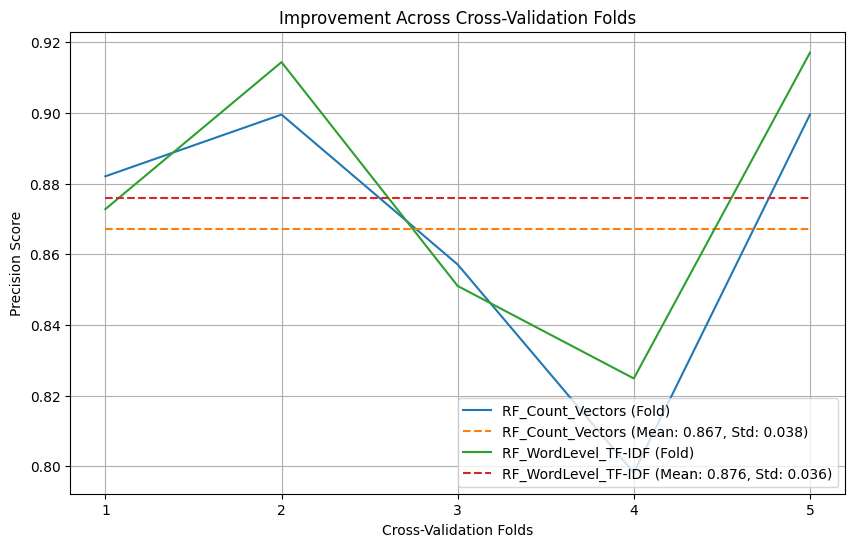

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_precision['Model'][4:6].to_list()
test_roc_auc_cv1 = df_cv_precision['test_prec_cv1'][4:6].to_list()
test_roc_auc_cv2 = df_cv_precision['test_prec_cv2'][4:6].to_list()
test_roc_auc_cv3 = df_cv_precision['test_prec_cv3'][4:6].to_list()
test_roc_auc_cv4 = df_cv_precision['test_prec_cv4'][4:6].to_list()
test_roc_auc_cv5 = df_cv_precision['test_prec_cv5'][4:6].to_list()
test_roc_auc_mean = df_cv_precision['test_prec_mean'][4:6].to_list()
test_roc_auc_std = df_cv_precision['test_prec_std'][4:6].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Precision Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_precision[4:6]

,Model,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std
0,RF_Count_Vectors,0.882096,0.899563,0.857143,0.798206,0.899543,0.86731,0.037886
0,RF_WordLevel_TF-IDF,0.872807,0.914414,0.851064,0.824885,0.917073,0.876049,0.035798


## XGBoost

### F1

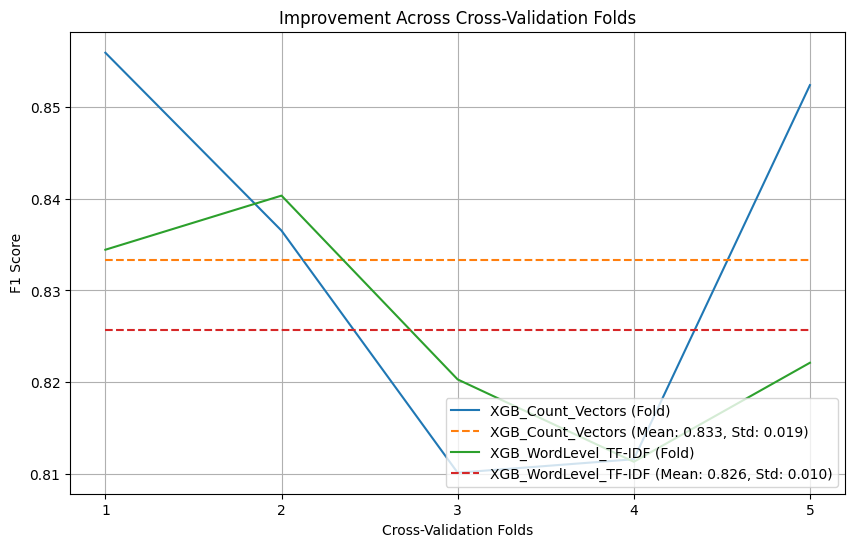

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][6:8].to_list()
test_roc_auc_cv1 = df_cv_f1['test_f1-score_cv1'][6:8].to_list()
test_roc_auc_cv2 = df_cv_f1['test_f1-score_cv2'][6:8].to_list()
test_roc_auc_cv3 = df_cv_f1['test_f1-score_cv3'][6:8].to_list()
test_roc_auc_cv4 = df_cv_f1['test_f1-score_cv4'][6:8].to_list()
test_roc_auc_cv5 = df_cv_f1['test_f1-score_cv5'][6:8].to_list()
test_roc_auc_mean = df_cv_f1['test_f1-score_mean'][6:8].to_list()
test_roc_auc_std = df_cv_f1['test_f1-score_std'][6:8].to_list()


for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('F1 Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_f1[6:8]

,Model,test_f1-score_cv1,test_f1-score_cv2,test_f1-score_cv3,test_f1-score_cv4,test_f1-score_cv5,test_f1-score_mean,test_f1-score_std
0,XGB_Count_Vectors,0.855914,0.836518,0.810127,0.811594,0.852381,0.833307,0.019463
0,XGB_WordLevel_TF-IDF,0.834437,0.840336,0.820296,0.811321,0.822115,0.825701,0.010386


### ROC

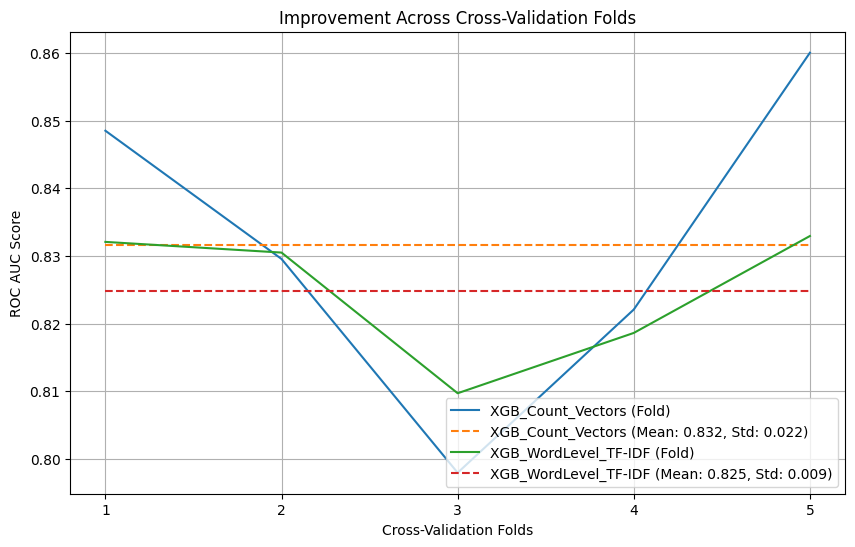

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_roc_auc['Model'][6:8].to_list()
test_roc_auc_cv2 = df_cv_roc_auc['test_roc_auc_cv2'][6:8].to_list()
test_roc_auc_cv1 = df_cv_roc_auc['test_roc_auc_cv1'][6:8].to_list()
test_roc_auc_cv3 = df_cv_roc_auc['test_roc_auc_cv3'][6:8].to_list()
test_roc_auc_cv4 = df_cv_roc_auc['test_roc_auc_cv4'][6:8].to_list()
test_roc_auc_cv5 = df_cv_roc_auc['test_roc_auc_cv5'][6:8].to_list()
test_roc_auc_mean = df_cv_roc_auc['test_roc_auc_mean'][6:8].to_list()
test_roc_auc_std = df_cv_roc_auc['test_roc_auc_std'][6:8].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('ROC AUC Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_roc_auc[6:8]

,Model,test_roc_auc_cv1,test_roc_auc_cv2,test_roc_auc_cv3,test_roc_auc_cv4,test_roc_auc_cv5,test_roc_auc_mean,test_roc_auc_std
0,XGB_Count_Vectors,0.848525,0.829555,0.797936,0.822078,0.860061,0.831631,0.021562
0,XGB_WordLevel_TF-IDF,0.832079,0.830499,0.809694,0.818615,0.832949,0.824767,0.009147


### Recall

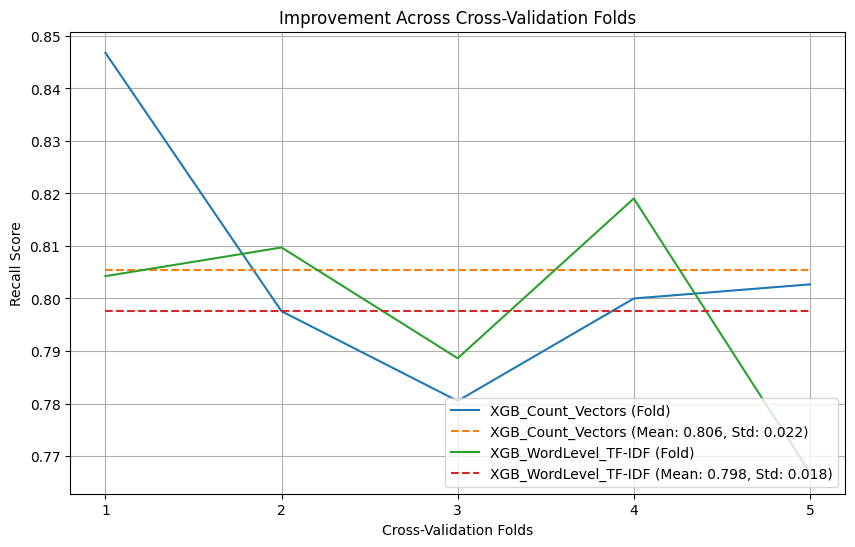

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_recall['Model'][6:8].to_list()
test_roc_auc_cv1 = df_cv_recall['test_recall_cv1'][6:8].to_list()
test_roc_auc_cv2 = df_cv_recall['test_recall_cv2'][6:8].to_list()
test_roc_auc_cv3 = df_cv_recall['test_recall_cv3'][6:8].to_list()
test_roc_auc_cv4 = df_cv_recall['test_recall_cv4'][6:8].to_list()
test_roc_auc_cv5 = df_cv_recall['test_recall_cv5'][6:8].to_list()
test_roc_auc_mean = df_cv_recall['test_recall_mean'][6:8].to_list()
test_roc_auc_std = df_cv_recall['test_recall_std'][6:8].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Recall Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_recall[6:8]

,Model,test_recall_cv1,test_recall_cv2,test_recall_cv3,test_recall_cv4,test_recall_cv5,test_recall_mean,test_recall_std
0,XGB_Count_Vectors,0.846809,0.797571,0.780488,0.8,0.802691,0.805512,0.022059
0,XGB_WordLevel_TF-IDF,0.804255,0.809717,0.788618,0.819048,0.766816,0.797691,0.018327


### Precision

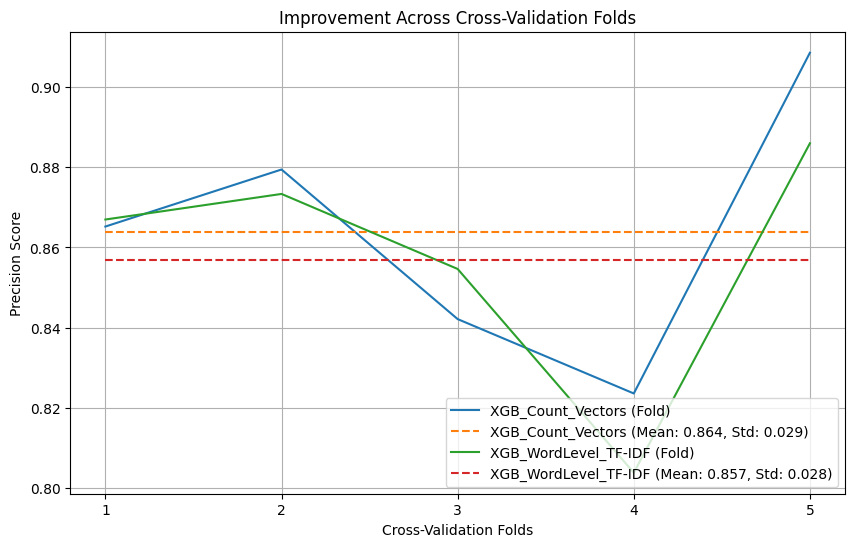

In [ ]:
plt.figure(figsize=(10, 6))
model_names = df_cv_precision['Model'][6:8].to_list()
test_roc_auc_cv1 = df_cv_precision['test_prec_cv1'][6:8].to_list()
test_roc_auc_cv2 = df_cv_precision['test_prec_cv2'][6:8].to_list()
test_roc_auc_cv3 = df_cv_precision['test_prec_cv3'][6:8].to_list()
test_roc_auc_cv4 = df_cv_precision['test_prec_cv4'][6:8].to_list()
test_roc_auc_cv5 = df_cv_precision['test_prec_cv5'][6:8].to_list()
test_roc_auc_mean = df_cv_precision['test_prec_mean'][6:8].to_list()
test_roc_auc_std = df_cv_precision['test_prec_std'][6:8].to_list()

for i, model in enumerate(model_names):
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_cv1[i], test_roc_auc_cv2[i], test_roc_auc_cv3[i], test_roc_auc_cv4[i], test_roc_auc_cv5[i]], label=f'{model} (Fold)')
    plt.plot([1, 2, 3, 4, 5], [test_roc_auc_mean[i]] * 5, linestyle='--',
             label=f'{model} (Mean: {test_roc_auc_mean[i]:.3f}, Std: {test_roc_auc_std[i]:.3f})')

plt.xlabel('Cross-Validation Folds')
plt.ylabel('Precision Score')
plt.title('Improvement Across Cross-Validation Folds')
plt.xticks(list(range(1, 6)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_cv_precision[6:8]

,Model,test_prec_cv1,test_prec_cv2,test_prec_cv3,test_prec_cv4,test_prec_cv5,test_prec_mean,test_prec_std
0,XGB_Count_Vectors,0.865217,0.879464,0.842105,0.823529,0.908629,0.863789,0.029494
0,XGB_WordLevel_TF-IDF,0.866972,0.873362,0.854626,0.803738,0.88601,0.856942,0.028465
